# 02 — Embeddings, EDA, Cartography, Clustering

This notebook loads `items.parquet` and produces:

- `morph.parquet` (morphology/QC features)
- modality embeddings:
  - image embeddings (torchvision ResNet-50)
  - text embeddings (TF-IDF → SVD dense vectors)
  - morphology embeddings (standardized numeric features)
- fused super-vector (concat + PCA)
- 2D map (UMAP if installed, otherwise PCA fallback)
- clustering (HDBSCAN if installed, otherwise KMeans fallback)
- EDA catalog outputs (`exports/eda/*.json`)

Everything is checkpointed under `checkpoints/`.


## PR changes in this notebook (unbiased notes)

### 1) Text modality: label leakage removed
We no longer template text as `Label=...`. The default is now **no-label text** (or empty text) controlled by:

- `embeddings.text.use_text_modality`
- `embeddings.text.text_template_version = v2_no_label`

**Pros:** keeps fusion/clustering truly unsupervised and avoids inflated purity metrics.  
**Cons:** many patch datasets have low-entropy metadata, so text may add little/no signal and should be dropped.

### 2) Embedding versions (ablation-ready)
We now (re)generate multiple fused embeddings:

- image-only
- image + morphology
- full fusion (only if text is enabled *and* meaningful)

This makes it easier to justify which modalities help.

### 3) Clustering overhaul (demo defensibility)
Default clustering is now **UMAP(metric='cosine') → HDBSCAN(metric='euclidean')** with:

- parameter sweep (UMAP + HDBSCAN)
- logged noise %, #clusters, cluster sizes, purity, and silhouette/DB index
- per-run audit plots (UMAP2D colored by predicted cluster vs ground-truth label + cluster size histogram)
- a KMeans baseline that never returns noise

**Pros:** more stable clusters, transparent selection of “best run”, audit artifacts for demos.  
**Cons:** HDBSCAN can still return substantial noise (dataset dependent), and UMAP/HDBSCAN add optional dependencies.

### 4) Model choice (ResNet vs UNI) — quick trade-off
- **ResNet50 (torchvision):** easy, fast, widely available; but not histopathology-specialized.
- **UNI (MahmoodLab):** often better domain alignment and retrieval; but heavier, needs model weights, GPU, and careful licensing/packaging.


## Math notes (Embeddings $\rightarrow$ Fusion $\rightarrow$ Cartography)

These notes are intentionally detailed because *small implementation choices* (normalization, distance metrics,
fusion strategy) have large downstream effects on the map and clusters.

### 1) Representations and distance

We have a set of items $i \in \{1,\dots,N\}$. Each item can have multiple modalities:

- image: $x_i^{(img)} \in \mathbb{R}^{d_{img}}$
- text: $x_i^{(txt)} \in \mathbb{R}^{d_{txt}}$
- morphology: $x_i^{(morph)} \in \mathbb{R}^{d_{morph}}$

A key decision is **how to compare items**.

Common choices:

- Euclidean distance: $\lVert u-v\rVert_2$
- Cosine distance: $1 - \dfrac{u^\top v}{\lVert u\rVert \,\lVert v\rVert}$

Cosine is often preferable for embeddings because:
1. many embedding models are trained with cosine / dot-product objectives
2. the **direction** contains the semantic signal, while the norm may vary due to nuisance factors.

### 2) Normalization is not optional

If we concatenate modalities, the feature with the largest scale dominates.

Let $z_i = [x_i^{(img)} \; ; \; x_i^{(txt)} \; ; \; x_i^{(morph)}]$. If $x^{(img)}$ has variance $100\times$ larger than
$x^{(txt)}$, then clustering/map mostly reflects image features only.

Therefore we standardize:

$$
\tilde{z}_{i,j} = \frac{z_{i,j} - \mu_j}{\sigma_j + \epsilon}
$$

where $\mu_j$ and $\sigma_j$ are computed across items for each feature dimension $j$.

### 3) Fusion by concatenation + PCA

Concatenation yields a high-dimensional vector $\tilde{z}_i \in \mathbb{R}^{d_{tot}}$.

We often reduce dimension with PCA:

- Compute covariance: $C = \dfrac{1}{N}\sum_i (\tilde{z}_i - \bar{z})(\tilde{z}_i - \bar{z})^\top$
- Eigen-decompose: $C = V\Lambda V^\top$
- Keep top $k$ eigenvectors: $V_k$
- Project: $y_i = V_k^\top (\tilde{z}_i - \bar{z})$

PCA is useful because:
- it removes linear correlations between concatenated features
- it compresses to a manageable size for kNN / UMAP / clustering
- it reduces noise if small eigenvalues correspond to noisy dimensions

But PCA is **global linear**: it can discard small nonlinear manifolds.

### 4) Why 2D maps are tricky

Any 2D projection loses information. A "good" map should preserve *local neighborhoods* rather than
global geometry.

If the goal is exploratory cartography:
- preserve nearest neighbors (who is near whom)
- accept global distortions

### 5) UMAP: a graph + fuzzy simplicial sets

UMAP builds a weighted kNN graph:

- find $k$ nearest neighbors for each point under a metric (often cosine)
- compute local connectivity weights using a smooth kernel with local radius

Then it optimizes a 2D embedding by minimizing cross-entropy between:
- high-dimensional fuzzy graph
- low-dimensional fuzzy graph

Key hyperparameters:

- `n_neighbors` ($k$): controls local vs global tradeoff
  - small $k$ $\rightarrow$ very local clusters
  - large $k$ $\rightarrow$ smoother global structure

- `min_dist`: controls how tightly points pack
  - small $\rightarrow$ tighter clusters
  - large $\rightarrow$ more spread out

### 6) Clustering in the fused space vs in 2D

You should cluster in the **high-dimensional fused space**, not the 2D map.
2D projections can create artificial clusters.

We do:
- cluster on fused embeddings (or PCA-reduced fused)
- then only *visualize* cluster assignment on the 2D map

### 7) HDBSCAN intuition (density clustering)

HDBSCAN is a hierarchical density-based method:
- estimates density via kNN distances
- constructs a hierarchy of clusters over density levels
- extracts stable clusters

It naturally handles:
- variable-density clusters
- noise points (label = $-1$)

If HDBSCAN isn't available, KMeans is a baseline:
- assumes spherical clusters in Euclidean space
- requires choosing $K$

### 8) Similarity edges for the knowledge graph

We build kNN edges using cosine similarity in fused space.

For each item $i$:
- compute nearest neighbors $j$
- define edge weight $w_{ij} = \max(0, \cos(x_i, x_j))$ (or $1 - d_{cos}$)

These edges form a graph that can be:
- exported to Neo4j / RDF
- used for cluster explanation (neighbors explain a point)
- used as input to graph algorithms (community detection, centrality)

### 9) A note on reproducibility

Stochastic components:
- sampling (SAFE_MODE)
- PCA randomness (minor)
- UMAP initialization / optimization
- KMeans init

We set a single seed and log it.
This makes results largely reproducible, but GPU nondeterminism can still exist.

### 10) Naming clusters in a *scientific* but human-readable way (purity + entropy)

Clustering gives us an integer $c_i \in \{0,1,\dots,K-1\}$ for each item $i$, but integers are_


## Pipeline walkthrough (what each cell is doing)

This notebook is intentionally "checkpoint-first": every expensive step writes a `.parquet` file so you can resume from the middle.
Conceptually, we go from **data** \(\rightarrow\) **embeddings** \(\rightarrow\) **fusion** \(\rightarrow\) **2D cartography** \(\rightarrow\) **clusters**.

1) **Embeddings:** each item (image patch) is mapped to vectors \(x_i^{(img)}, x_i^{(txt)}, x_i^{(morph)}\).  
2) **Fusion:** we build a single representation \(z_i\) (e.g., concatenation + normalization), so we can compare items consistently.  
3) **Cartography:** we compute a 2D map \(y_i \in \mathbb{R}^2\) that preserves neighborhood structure (UMAP / t-SNE).  
4) **Clustering:** we assign cluster IDs \(c_i\), then *name* clusters using label statistics (purity/entropy).  

**For a layperson:** think of Google Photos: images become numbers ("embeddings"), similar photos are placed near each other on a map,
and clusters become albums. The "cluster name" step is like auto-titling an album: *"mostly tumor patches"* vs *"mixed stroma + mucosa"*.


<a id="C0.0"></a>
### Cell C0.0 — Bootstrap (Drive, PROJECT_ROOT, runtime)

- **Purpose:** Mount Drive, resolve PROJECT_ROOT, load config, init runtime.
- **Inputs:** HISTO_PROJECT_ROOT (optional), pipeline_config.yaml
- **Outputs:** PROJECT_ROOT, cfg, SAFE_MODE
- **Depends on:** None
- **Writes checkpoints:** checkpoints/_STATE.json


In [1]:
import os, sys
from pathlib import Path
import yaml

IN_COLAB = "google.colab" in sys.modules

def _mount_drive(mountpoint: str = "/content/drive", max_tries: int = 3, timeout_ms: int = 300000) -> bool:
    """Robust Google Drive mount with retries (Colab).

    Returns True if /content/drive/MyDrive becomes available.
    """
    if not IN_COLAB:
        return True
    try:
        from google.colab import drive  # type: ignore
    except Exception as e:
        print("⚠️ google.colab not available:", repr(e))
        return False

    import time

    mp = Path(mountpoint)
    if (mp / "MyDrive").exists():
        return True

    last = None
    for t in range(max_tries):
        try:
            kwargs = {}
            if t > 0:
                kwargs["force_remount"] = True
            # Some Colab versions accept timeout_ms; ignore if not.
            kwargs["timeout_ms"] = timeout_ms
            try:
                drive.mount(mountpoint, **kwargs)
            except TypeError:
                kwargs.pop("timeout_ms", None)
                if kwargs:
                    drive.mount(mountpoint, **kwargs)
                else:
                    drive.mount(mountpoint)

            if (mp / "MyDrive").exists():
                return True
        except Exception as e:
            last = e
            time.sleep(2)

    print("❌ Google Drive mount failed.")
    print("Fixes to try:")
    print("  1) Runtime ▸ Restart runtime, then re-run this cell")
    print("  2) Run: from google.colab import drive; drive.flush_and_unmount(); drive.mount('/content/drive', force_remount=True)")
    print("  3) In your browser, allow third‑party cookies for colab.research.google.com")
    if last is not None:
        print("Last error:", repr(last))
    return False

if IN_COLAB and not _mount_drive():
    raise RuntimeError("Cannot continue without Google Drive mounted. Fix Drive mount and re-run this cell.")

# Optional hard-set:
os.environ["HISTO_PROJECT_ROOT"] = "/content/drive/MyDrive/mit/histopathology_202601012"

def resolve_project_root() -> Path:
    """Find the folder that contains pipeline_config.yaml + label_taxonomy.yaml."""
    ev = os.environ.get("HISTO_PROJECT_ROOT")
    if ev:
        p = Path(ev).expanduser()
        if (p / "pipeline_config.yaml").exists() and (p / "label_taxonomy.yaml").exists():
            return p
        raise FileNotFoundError(f"HISTO_PROJECT_ROOT is set but required files not found in: {p}")

    bases = [
        Path("/content/drive/MyDrive/mit"),
        Path("/content/drive/MyDrive"),
        Path("/content/drive/MyDrive"),
    ]
    required = ["pipeline_config.yaml", "label_taxonomy.yaml"]
    candidates = []
    for base in bases:
        if not base.exists():
            continue
        for p in base.glob("**/pipeline_config.yaml"):
            root = p.parent
            if all((root / rf).exists() for rf in required):
                candidates.append(root.resolve())
        if candidates:
            break

    candidates = sorted(set(candidates), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError(
            "Could not locate project root containing pipeline_config.yaml + label_taxonomy.yaml.\n"
            "Expected it somewhere under /content/drive/MyDrive/mit/.\n"
            "Fix: copy the project folder into Drive, OR set os.environ['HISTO_PROJECT_ROOT'] explicitly."
        )

    if len(candidates) > 1:
        print("⚠️ Multiple candidate project roots found; using newest. To force, set HISTO_PROJECT_ROOT.")
        for c in candidates[:5]:
            print("  -", c)

    return candidates[0]

PROJECT_ROOT = resolve_project_root().resolve()
os.environ["HISTO_PROJECT_ROOT"] = str(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("✅ PROJECT_ROOT =", PROJECT_ROOT)
print("sys.path[0] =", sys.path[0])

from histo_cartography.runtime import init_runtime, set_seed, health_check
from histo_cartography.paths import ensure_dirs

CONFIG_PATH = PROJECT_ROOT / "pipeline_config.yaml"
assert CONFIG_PATH.exists(), f"Missing {CONFIG_PATH}"
cfg = yaml.safe_load(CONFIG_PATH.read_text())

SAFE_MODE = bool(cfg.get("project", {}).get("safe_mode", True))
DEBUG_LEVEL = int(cfg.get("project", {}).get("debug_level", 1))

# Create standard directories
ensure_dirs(PROJECT_ROOT, [
    cfg["paths"]["log_dir"],
    cfg["paths"]["checkpoints_dir"],
    cfg["paths"]["data_raw_dir"],
    cfg["paths"]["data_staging_dir"],
    cfg["paths"]["exports_dir"],
    "exports/eda",
    "exports/cartography",
    "exports/kg",
])

init_runtime(
    PROJECT_ROOT,
    safe_mode=SAFE_MODE,
    debug_level=DEBUG_LEVEL,
    log_dir_rel=cfg["paths"]["log_dir"],
    checkpoint_dir_rel=cfg["paths"]["checkpoints_dir"],
)
set_seed(int(cfg.get("project", {}).get("seed", 1337)))

# Post-init sanity check
health_check(
    "BOOTSTRAP",
    namespace=globals(),
    require_files=[PROJECT_ROOT / "pipeline_config.yaml", PROJECT_ROOT / "label_taxonomy.yaml"],
    require_dirs=[PROJECT_ROOT / cfg["paths"]["checkpoints_dir"], PROJECT_ROOT / cfg["paths"]["exports_dir"]],
)

print("SAFE_MODE =", SAFE_MODE, "| DEBUG_LEVEL =", DEBUG_LEVEL)


Mounted at /content/drive
✅ PROJECT_ROOT = /content/drive/MyDrive/mit/histopathology_202601012
sys.path[0] = /content/drive/MyDrive/mit/histopathology_202601012


INFO:histo_cartography:Logging to: /content/drive/MyDrive/mit/histopathology_202601012/logs/run.jsonl
INFO:histo_cartography:Loaded existing STATE for resume mode
INFO:histo_cartography:Seeds set to 1337
DEBUG:histo_cartography:health_check ok


SAFE_MODE = True | DEBUG_LEVEL = 1


<a id="C0.1"></a>
### Cell C0.1 — Load items checkpoint

- **Purpose:** Load items.parquet from checkpoints/B/.
- **Inputs:** checkpoints/B/items.parquet
- **Outputs:** items_df
- **Depends on:** B4.0
- **Writes checkpoints:** None


In [2]:
from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.runtime import cell_context, health_check
from histo_cartography.debug_tools import display_df

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
items_path = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "B" / "items.parquet"

health_check("C0.1", require_files=[items_path], min_free_gb=0.5)

with cell_context("C0.1", purpose="Load items checkpoint", stage="C"):
    items_df = pd.read_parquet(items_path)

print("n_items =", len(items_df))
display_df(items_df, title="📄 items_df (loaded)", n=10)

if "label" in items_df.columns:
    try:
        from IPython.display import display
        display(items_df["label"].value_counts().head(20).to_frame("count"))
    except Exception:
        print(items_df["label"].value_counts().head(20))

DEBUG:histo_cartography:health_check ok
INFO:histo_cartography:▶️  C0.1: Load items checkpoint
INFO:histo_cartography:✅ C0.1 finished in 0.42s


n_items = 512
📄 items_df (loaded)
shape=(512, 9)


,item_id,source,split,label,text,image_path,width,height,mpp
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYEVWMFC,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
9,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYYTMTTH,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5


,count
label,
ADI,57
DEB,57
LYM,57
MUC,57
MUS,57
STR,57
NORM,57
TUM,57
BACK,56


<a id="C1.0"></a>
### Cell C1.0 — Compute morphology/QC features

- **Purpose:** Compute lightweight morphology-ish features from images (tissue coverage, blur, brightness, saturation).
- **Inputs:** items_df.image_path
- **Outputs:** morph_df
- **Depends on:** C0.1
- **Writes checkpoints:** checkpoints/C/morph.parquet (+ manifest)


In [3]:

from pathlib import Path
import yaml

from histo_cartography.runtime import cell_context, health_check
from histo_cartography.embeddings import compute_morphology_features
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C"
ckpt_dir.mkdir(parents=True, exist_ok=True)

morph_path = ckpt_dir / "morph.parquet"

max_items = int(cfg["data"]["max_items_safe"]) if SAFE_MODE else cfg["data"].get("max_items_full")
max_items = int(max_items) if max_items is not None else None

with cell_context("C1.0", purpose="Compute morphology features", stage="C", checkpoint_paths=[str(morph_path)]):
    if morph_path.exists():
        import pandas as pd
        morph_df = pd.read_parquet(morph_path)
        print("Loaded existing morph_df from checkpoint.")
    else:
        morph_df = compute_morphology_features(items_df, max_items=max_items)
        save_parquet(morph_df, morph_path)
        write_manifest(morph_path, schema_version=cfg["project"]["schema_version"], df=morph_df, key_cols=["item_id"])

print(morph_df.head())
print("morph_df cols:", list(morph_df.columns))


from histo_cartography.debug_tools import show_parquet
_ = show_parquet(morph_path, title="checkpoints/C/morph.parquet", n=10)


INFO:histo_cartography:▶️  C1.0: Compute morphology features
INFO:histo_cartography:✅ C1.0 finished in 0.47s


Loaded existing morph_df from checkpoint.
                                      item_id  morph_error      mean_r  \
0  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL            0  224.462153   
1  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM            0  234.861149   
2  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC            0  230.997848   
3  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER            0  215.190729   
4  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC            0  227.643196   

       mean_g      mean_b      std_r      std_g      std_b   mean_gray  \
0  206.149613  224.437978  26.533871  38.995551  25.759346  213.709323   
1  220.193698  233.449219  18.425649  30.947835  19.535261  226.074318   
2  218.373266  230.791574  20.240113  31.194043  21.557493  223.594607   
3  184.521385  209.915796  34.656161  52.600054  36.089298  196.579201   
4  209.525969  226.074558  24.808429  38.201199  26.941422  216.840422   

    std_gray  tissue_coverage  blur_var_lap   sat_mean    sat_std  w

,item_id,morph_error,mean_r,mean_g,mean_b,std_r,std_g,std_b,mean_gray,std_gray,tissue_coverage,blur_var_lap,sat_mean,sat_std,width,height
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,0,224.462153,206.149613,224.437978,26.533871,38.995551,25.759346,213.709323,33.337798,0.902782,408.122817,26.013094,29.523366,224,224
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,0,234.861149,220.193698,233.449219,18.425649,30.947835,19.535261,226.074318,25.591029,0.903480,218.804757,18.397660,21.556404,224,224
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,0,230.997848,218.373266,230.791574,20.240113,31.194043,21.557493,223.594607,26.571445,0.938317,316.168526,17.506019,23.084462,224,224
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,0,215.190729,184.521385,209.915796,34.656161,52.600054,36.089298,196.579201,44.836750,0.740414,55.485891,43.083725,39.587154,224,224
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,0,227.643196,209.525969,226.074558,24.808429,38.201199,26.941422,216.840422,32.574786,0.904795,511.881986,24.580596,28.358232,224,224
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,0,209.283402,182.501993,208.967136,32.323067,44.546704,35.965396,193.530752,39.190609,0.872349,1433.256759,42.622150,37.022444,224,224
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,0,212.458247,190.251096,214.844846,25.351603,36.773077,28.771662,199.699637,31.939416,0.908542,861.805490,35.492467,29.129475,224,224
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,0,225.676160,197.579062,218.730947,28.703720,48.910694,33.786436,208.398637,40.464764,0.817801,1057.024657,36.979512,38.856732,224,224
8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYEVWMFC,0,211.105867,180.928253,206.961057,40.863490,58.642315,41.541907,192.908980,50.816282,0.751993,50.780594,45.709044,44.612769,224,224
9,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYYTMTTH,0,215.144830,197.910356,216.941645,21.268970,30.557410,21.045227,205.237424,26.418904,0.935128,426.855411,25.588708,23.234747,224,224


In [4]:
import inspect, linecache
import histo_cartography.embeddings as emb

path = inspect.getfile(emb)
print("✅ histo_cartography.embeddings module file:", path)

# Show the lines around where users most commonly see indentation / SyntaxError issues
start, end = 150, 210
for ln in range(start, end + 1):
    s = linecache.getline(path, ln)
    if not s:
        continue
    print(f"{ln:4d} | {s}", end="")

✅ histo_cartography.embeddings module file: /content/drive/MyDrive/mit/histopathology_202601012/histo_cartography/embeddings.py
 150 |         df = df.sample(n=max_items, random_state=1337).reset_index(drop=True)
 151 | 
 152 |     exts = (".tif", ".tiff", ".png", ".jpg", ".jpeg")
 153 |     item_ids: List[str] = []
 154 |     vecs: List[np.ndarray] = []
 155 | 
 156 |     # Histogram bin edges in [0, 256)
 157 |     edges = np.linspace(0, 256, bins + 1, dtype=np.float32)
 158 | 
 159 |     for _, r in df.iterrows():
 160 |         p = Path(str(r[image_col]))
 161 |         if not p.exists() or (p.suffix.lower() not in exts):
 162 |             continue
 163 |         try:
 164 |             with Image.open(p) as im:
 165 |                 im = im.convert("RGB")
 166 |                 if resize:
 167 |                     im = im.resize(resize)
 168 |                 arr = np.asarray(im, dtype=np.float32)
 169 |         except Exception:
 170 |             continue
 171 | 
 172 |      

<a id="C2.0"></a>
### Cell C2.0 — Compute image embeddings

- **Purpose:** Compute image embeddings (torchvision ResNet-50).
- **Inputs:** items_df, image files
- **Outputs:** image_emb_df
- **Depends on:** C0.1
- **Writes checkpoints:** checkpoints/C/image_embeddings.parquet (+ manifest)


In [5]:

from pathlib import Path
import yaml

from histo_cartography.runtime import cell_context
from histo_cartography.embeddings import embed_images_resnet50, get_device
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C"
ckpt_dir.mkdir(parents=True, exist_ok=True)

img_emb_path = ckpt_dir / "image_embeddings.parquet"

batch_size = int(cfg["embeddings"]["image"]["batch_size_safe"] if SAFE_MODE else cfg["embeddings"]["image"]["batch_size_full"])
prefer_gpu = bool(cfg["embeddings"]["image"].get("prefer_gpu", True))
device = get_device(prefer_gpu=prefer_gpu)

max_items = int(cfg["data"]["max_items_safe"]) if SAFE_MODE else cfg["data"].get("max_items_full")
max_items = int(max_items) if max_items is not None else None

with cell_context("C2.0", purpose="Compute image embeddings (ResNet-50)", stage="C", checkpoint_paths=[str(img_emb_path)]):
    if img_emb_path.exists():
        import pandas as pd
        image_emb_df = pd.read_parquet(img_emb_path)
        print("Loaded existing image_emb_df from checkpoint.")
    else:
        image_emb_df = embed_images_resnet50(items_df, batch_size=batch_size, device=device, max_items=max_items)
        save_parquet(image_emb_df, img_emb_path)
        write_manifest(img_emb_path, schema_version=cfg["project"]["schema_version"], df=image_emb_df, key_cols=["item_id"])

print("image_emb_df:", image_emb_df.shape)
print(image_emb_df.head())


from histo_cartography.debug_tools import show_parquet
_ = show_parquet(img_emb_path, title="checkpoints/C/image_embeddings.parquet", n=10)


INFO:histo_cartography:▶️  C2.0: Compute image embeddings (ResNet-50)
INFO:histo_cartography:✅ C2.0 finished in 1.83s


Loaded existing image_emb_df from checkpoint.
image_emb_df: (512, 5)
                                      item_id modality  \
0  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL    image   
1  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM    image   
2  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC    image   
3  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER    image   
4  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC    image   

                        model_id   dim  \
0  torchvision/resnet50_imagenet  2048   
1  torchvision/resnet50_imagenet  2048   
2  torchvision/resnet50_imagenet  2048   
3  torchvision/resnet50_imagenet  2048   
4  torchvision/resnet50_imagenet  2048   

                                              vector  
0  [0.5589615702629089, 0.07792720943689346, 0.50...  
1  [0.3780534565448761, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0988510474562645, 0.03204520791769028, 0.01...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0187046416103...  
4  [0.0, 0.014218938536942005, 0.1506246477365493...  

,item_id,modality,model_id,dim,vector
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,image,torchvision/resnet50_imagenet,2048,"[0.5589615702629089, 0.07792720943689346, 0.50..."
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,image,torchvision/resnet50_imagenet,2048,"[0.3780534565448761, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,image,torchvision/resnet50_imagenet,2048,"[0.0988510474562645, 0.03204520791769028, 0.01..."
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,image,torchvision/resnet50_imagenet,2048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0187046416103..."
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,image,torchvision/resnet50_imagenet,2048,"[0.0, 0.014218938536942005, 0.1506246477365493..."
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,image,torchvision/resnet50_imagenet,2048,"[0.05810416862368584, 0.12287670373916626, 0.0..."
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,image,torchvision/resnet50_imagenet,2048,"[0.08134860545396805, 0.07267668098211288, 0.0..."
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,image,torchvision/resnet50_imagenet,2048,"[0.007084301672875881, 0.0, 0.0028630066663026..."
8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYEVWMFC,image,torchvision/resnet50_imagenet,2048,"[0.0, 0.013016910292208195, 0.0, 0.0, 0.0, 0.0..."
9,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYYTMTTH,image,torchvision/resnet50_imagenet,2048,"[0.1370788961648941, 0.04798337444663048, 0.10..."


<a id="C3.0"></a>
### Cell C3.0 — Compute text embeddings

- **Purpose:** Compute text embeddings via TF-IDF + SVD (dense).
- **Inputs:** items_df.text
- **Outputs:** text_emb_df
- **Depends on:** C0.1
- **Writes checkpoints:** checkpoints/C/text_embeddings.parquet (+ manifest)


In [6]:

from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.runtime import cell_context
from histo_cartography.embeddings import embed_text_tfidf_svd
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C"
ckpt_dir.mkdir(parents=True, exist_ok=True)

txt_emb_path = ckpt_dir / "text_embeddings.parquet"

text_cfg = (cfg.get("embeddings") or {}).get("text") or {}
USE_TEXT_MODALITY = bool(text_cfg.get("use_text_modality", False))
SVD_DIM = int(text_cfg.get("svd_dim", 128))
MAX_FEATURES = int(text_cfg.get("max_features", 8192))
TEXT_TEMPLATE_VERSION = str(text_cfg.get("text_template_version", "v2_no_label"))

# Entropy checks: if text doesn't vary, it can't help fusion.
if "text" not in items_df.columns:
    items_df["text"] = ""

# If we are running in resume mode and the staged items table was created by an older notebook
# version, it may still contain label leakage in text. We defensively blank it out when using v2_no_label.
if TEXT_TEMPLATE_VERSION == "v2_no_label":
    leakage_mask = items_df["text"].astype(str).str.contains("Label=", regex=False)
    if leakage_mask.any():
        n_leak = int(leakage_mask.sum())
        print(f"⚠️ Detected {n_leak} text rows containing 'Label=' → blanking text to prevent leakage.")
        items_df["text"] = ""


n_unique_texts = int(items_df["text"].fillna("").astype(str).nunique())
n_labels = int(items_df["label"].nunique()) if "label" in items_df.columns else 0

print("use_text_modality =", USE_TEXT_MODALITY)
print("text_template_version =", TEXT_TEMPLATE_VERSION)
print("n_unique_texts =", n_unique_texts)
print("n_unique_labels =", n_labels)

# Heuristic: we only keep text in fusion if it has materially more unique strings than labels.
# (If it doesn't, it's likely low-entropy metadata or accidental label leakage.)
TEXT_IS_MEANINGFUL_FOR_FUSION = bool(USE_TEXT_MODALITY and (n_unique_texts > max(9, n_labels)))
print("text_is_meaningful_for_fusion =", TEXT_IS_MEANINGFUL_FOR_FUSION)

with cell_context(
    "C3.0",
    purpose="Compute text embeddings (TF-IDF+SVD) — no label fallback",
    stage="C",
    checkpoint_paths=[str(txt_emb_path)],
):
    if txt_emb_path.exists():
        text_embeddings_df = pd.read_parquet(txt_emb_path)
        print("Loaded:", txt_emb_path)
    else:
        if not USE_TEXT_MODALITY:
            # Keep schema-compatible placeholder vectors so downstream code can run.
            text_embeddings_df = pd.DataFrame(
                {
                    "item_id": items_df["item_id"].tolist(),
                    "modality": "text",
                    "model_id": "text/disabled",
                    "dim": 1,
                    "vector": [[0.0] for _ in range(len(items_df))],
                }
            )
            print("Text modality disabled by config → writing placeholder embeddings.")
        else:
            # IMPORTANT: allow_label_fallback=False prevents accidental label leakage if `text` is missing.
            text_embeddings_df = embed_text_tfidf_svd(
                items_df,
                n_components=SVD_DIM,
                max_features=MAX_FEATURES,
                allow_label_fallback=False,
            )
            print("Computed text embeddings:", text_embeddings_df.shape)

        save_parquet(text_embeddings_df, txt_emb_path)
        write_manifest(
            txt_emb_path,
            {
                "modality": "text",
                "engine": "tfidf_svd",
                "svd_dim": SVD_DIM,
                "max_features": MAX_FEATURES,
                "use_text_modality": USE_TEXT_MODALITY,
                "text_template_version": TEXT_TEMPLATE_VERSION,
                "n_unique_texts": n_unique_texts,
            },
        )

# Backwards-compatible alias (older cells expect text_emb_df)
text_emb_df = text_embeddings_df


INFO:histo_cartography:▶️  C3.0: Compute text embeddings (TF-IDF+SVD) — no label fallback


use_text_modality = False
text_template_version = v2_no_label
n_unique_texts = 1
n_unique_labels = 9
text_is_meaningful_for_fusion = False
Loaded: /content/drive/MyDrive/mit/histopathology_202601012/checkpoints/C/text_embeddings.parquet


INFO:histo_cartography:✅ C3.0 finished in 0.19s


<a id="C4.0"></a>
### Cell C4.0 — Embed morphology features

- **Purpose:** Standardize numeric morphology features and treat as a modality embedding.
- **Inputs:** morph_df
- **Outputs:** morph_emb_df
- **Depends on:** C1.0
- **Writes checkpoints:** checkpoints/C/morph_embeddings.parquet (+ manifest)


In [7]:

from pathlib import Path
import yaml

from histo_cartography.runtime import cell_context
from histo_cartography.embeddings import embed_morphology_features
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C"
ckpt_dir.mkdir(parents=True, exist_ok=True)

morph_emb_path = ckpt_dir / "morph_embeddings.parquet"

with cell_context("C4.0", purpose="Embed morphology features", stage="C", checkpoint_paths=[str(morph_emb_path)]):
    if morph_emb_path.exists():
        import pandas as pd
        morph_emb_df = pd.read_parquet(morph_emb_path)
        print("Loaded existing morph_emb_df from checkpoint.")
    else:
        morph_emb_df = embed_morphology_features(morph_df)
        save_parquet(morph_emb_df, morph_emb_path)
        write_manifest(morph_emb_path, schema_version=cfg["project"]["schema_version"], df=morph_emb_df, key_cols=["item_id"])

print("morph_emb_df:", morph_emb_df.shape)
print(morph_emb_df.head())


from histo_cartography.debug_tools import show_parquet
_ = show_parquet(morph_emb_path, title="checkpoints/C/morph_embeddings.parquet", n=10)


INFO:histo_cartography:▶️  C4.0: Embed morphology features
INFO:histo_cartography:✅ C4.0 finished in 0.19s


Loaded existing morph_emb_df from checkpoint.
morph_emb_df: (512, 5)
                                      item_id    modality  \
0  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL  morphology   
1  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM  morphology   
2  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC  morphology   
3  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER  morphology   
4  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC  morphology   

                model_id  dim  \
0  morph_standardized/15   15   
1  morph_standardized/15   15   
2  morph_standardized/15   15   
3  morph_standardized/15   15   
4  morph_standardized/15   15   

                                              vector  
0  [0.0, 1.4539846181869507, 2.0059986114501953, ...  
1  [0.0, 1.8219432830810547, 2.3683664798736572, ...  
2  [0.0, 1.685244083404541, 2.3213953971862793, 1...  
3  [0.0, 1.125923991203308, 1.4479435682296753, 0...  
4  [0.0, 1.5665428638458252, 2.09311580657959, 1....  
📄 checkpoints/C/morph_embeddings.pa

,item_id,modality,model_id,dim,vector
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,morphology,morph_standardized/15,15,"[0.0, 1.4539846181869507, 2.0059986114501953, ..."
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,morphology,morph_standardized/15,15,"[0.0, 1.8219432830810547, 2.3683664798736572, ..."
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,morphology,morph_standardized/15,15,"[0.0, 1.685244083404541, 2.3213953971862793, 1..."
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,morphology,morph_standardized/15,15,"[0.0, 1.125923991203308, 1.4479435682296753, 0..."
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,morphology,morph_standardized/15,15,"[0.0, 1.5665428638458252, 2.09311580657959, 1...."
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,morphology,morph_standardized/15,15,"[0.0, 0.9168988466262817, 1.3958388566970825, ..."
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,morphology,morph_standardized/15,15,"[0.0, 1.0292377471923828, 1.5957825183868408, ..."
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,morphology,morph_standardized/15,15,"[0.0, 1.496941089630127, 1.7848598957061768, 1..."
8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYEVWMFC,morphology,morph_standardized/15,15,"[0.0, 0.9813850522041321, 1.3552329540252686, ..."
9,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYYTMTTH,morphology,morph_standardized/15,15,"[0.0, 1.1242998838424683, 1.793407917022705, 1..."


<a id="C5.0"></a>
### Cell C5.0 — Fuse modalities into a super-vector

- **Purpose:** Concatenate image/text/morph embeddings and PCA-reduce to target_dim.
- **Inputs:** image_emb_df, text_emb_df, morph_emb_df
- **Outputs:** fused_emb_df
- **Depends on:** C2.0,C3.0,C4.0
- **Writes checkpoints:** checkpoints/C/fused_embeddings.parquet (+ manifest)


In [10]:

from pathlib import Path
import yaml
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from histo_cartography.runtime import cell_context
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest

# --- Inline definitions of missing functions ---

def align_embeddings(emb_dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """
    Aligns multiple embedding dataframes on 'item_id'.
    Returns a DataFrame with [item_id, vector_0, vector_1, ...].
    Inner join is used (only items present in all modalities).
    """
    if not emb_dfs:
        return pd.DataFrame()

    # Start with the first one
    merged = emb_dfs[0][["item_id", "vector"]].rename(columns={"vector": "vector_0"})

    for i, df in enumerate(emb_dfs[1:], start=1):
        # We assume 'item_id' and 'vector' exist
        next_df = df[["item_id", "vector"]].rename(columns={"vector": f"vector_{i}"})
        merged = merged.merge(next_df, on="item_id", how="inner")

    return merged

def fuse_embeddings_concat_pca(
    aligned_df: pd.DataFrame,
    target_dim: int = 32,
    random_state: int = 1337
) -> pd.DataFrame:
    """
    Concatenates aligned vectors, normalizes, runs PCA, and returns formatted embedding DF.
    """
    if aligned_df.empty:
        return pd.DataFrame(columns=["item_id", "modality", "model_id", "dim", "vector"])

    # Extract vectors into a matrix
    # aligned_df has columns vector_0, vector_1, ...
    vec_cols = [c for c in aligned_df.columns if c.startswith("vector_")]

    # Stack vectors: N items x (D1 + D2 + ...)
    Xs = []
    for c in vec_cols:
        # stack list of arrays
        col_vecs = np.stack(aligned_df[c].values)
        # Standardize per modality to avoid dominance
        scaler = StandardScaler()
        col_vecs = scaler.fit_transform(col_vecs)
        Xs.append(col_vecs)

    X_concat = np.concatenate(Xs, axis=1)

    # PCA
    n_samples, n_features = X_concat.shape
    n_components = min(target_dim, n_samples, n_features)

    pca = PCA(n_components=n_components, random_state=random_state)
    X_reduced = pca.fit_transform(X_concat)

    # L2 normalize
    norms = np.linalg.norm(X_reduced, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    X_reduced = X_reduced / norms

    # Construct output DF
    out = aligned_df[["item_id"]].copy()
    out["modality"] = "fused"
    out["model_id"] = f"concat_pca_{n_components}"
    out["dim"] = n_components
    out["vector"] = list(X_reduced)

    return out

# --- End inline definitions ---

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C"
ckpt_dir.mkdir(parents=True, exist_ok=True)

target_dim = int(cfg["embeddings"]["fusion"]["target_dim"])

# Decide whether to include text in the *fusion* (not just whether to compute it).
# We only include text if:
#   - config enables it, AND
#   - text is high-entropy enough to be meaningful (see C3.0).
include_text_in_fusion = bool(globals().get("TEXT_IS_MEANINGFUL_FOR_FUSION", False))

fused_paths = {
    "image_only": ckpt_dir / "fused_embeddings__image.parquet",
    "image_morph": ckpt_dir / "fused_embeddings__image_morph.parquet",
    "full_fusion": ckpt_dir / "fused_embeddings__full.parquet",
}
default_fused_path = ckpt_dir / "fused_embeddings.parquet"  # backwards compatible

def _fuse_and_cache(name, emb_dfs):
    out_path = fused_paths[name]
    if out_path.exists():
        return out_path, None

    aligned = align_embeddings(emb_dfs)
    fused = fuse_embeddings_concat_pca(aligned, target_dim=target_dim)
    save_parquet(fused, out_path)

    # Construct metadata for manifest
    meta = {
        "embedding_version": str(fused.get("model_id").iloc[0]) if len(fused) else "",
        "fusion_strategy": "concat_pca",
        "target_dim": target_dim,
        "modalities": [str(df.get("modality").iloc[0]) for df in emb_dfs if len(df)],
        "include_text_in_fusion": include_text_in_fusion,
    }
    write_manifest(out_path, schema_version=cfg["project"]["schema_version"], extra=meta)
    return out_path, fused

with cell_context("C5.0", purpose="Fuse modalities (ablation-ready versions)", stage="C"):
    # Always compute / cache these two
    _p_img, _img_fused = _fuse_and_cache("image_only", [image_emb_df])
    _p_img_morph, _img_morph_fused = _fuse_and_cache("image_morph", [image_emb_df, morph_emb_df])

    # Only compute full fusion if text is enabled *and* meaningful.
    if include_text_in_fusion:
        _p_full, _full_fused = _fuse_and_cache("full_fusion", [image_emb_df, morph_emb_df, text_emb_df])
    else:
        _p_full, _full_fused = (fused_paths["full_fusion"], None)
        print("Skipping full_fusion: text is disabled or low-entropy (see C3.0).")

    # Load all versions into memory for later EDA
    fused_versions = {}
    for name, p in fused_paths.items():
        if p.exists():
            fused_versions[name] = pd.read_parquet(p)

    # Choose default fused embedding for downstream clustering/KG
    DEFAULT_FUSED_VERSION = "full_fusion" if include_text_in_fusion and fused_paths["full_fusion"].exists() else "image_morph"
    fused_emb_df = fused_versions[DEFAULT_FUSED_VERSION]
    print("DEFAULT_FUSED_VERSION =", DEFAULT_FUSED_VERSION, "→", fused_emb_df.shape)

    # Keep backwards-compatible checkpoint name for downstream notebooks
    save_parquet(fused_emb_df, default_fused_path)

    # Write manifest for default path
    default_meta = {
        "default_fused_version": DEFAULT_FUSED_VERSION,
        "target_dim": target_dim,
        "include_text_in_fusion": include_text_in_fusion,
    }
    write_manifest(default_fused_path, schema_version=cfg["project"]["schema_version"], extra=default_meta)

print("Available fused versions:", list(globals().get("fused_versions", {}).keys()))
print("fused_emb_df:", fused_emb_df.shape)


INFO:histo_cartography:▶️  C5.0: Fuse modalities (ablation-ready versions)
INFO:histo_cartography:Saved parquet
INFO:histo_cartography:Wrote manifest


Skipping full_fusion: text is disabled or low-entropy (see C3.0).
DEFAULT_FUSED_VERSION = image_morph → (512, 5)


INFO:histo_cartography:Saved parquet
INFO:histo_cartography:Wrote manifest
INFO:histo_cartography:✅ C5.0 finished in 1.78s


Available fused versions: ['image_only', 'image_morph']
fused_emb_df: (512, 5)


<a id="C5.1"></a>
### Cell C5.1 — Quick multimodal sanity check: kNN label consistency

**Purpose:** compare embedding versions (image-only vs image+morph vs full fusion) using a simple retrieval-style metric.

- **Pros:** fast, interpretable, good for deciding whether a modality actually helps.
- **Cons:** this uses ground-truth labels *only for evaluation*; do not use it to tune embeddings in a way you later claim is unsupervised.


In [11]:

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

def knn_within_label_rate(emb_df: pd.DataFrame, labels: pd.Series, *, k: int = 10, metric: str = "cosine") -> float:
    emb_df = emb_df.copy()
    emb_df = emb_df[emb_df["item_id"].isin(labels.index)].sort_values("item_id").reset_index(drop=True)
    y = labels.loc[emb_df["item_id"]].to_numpy()
    X = np.array(emb_df["vector"].tolist(), dtype=np.float32)
    nn = NearestNeighbors(n_neighbors=min(int(k) + 1, len(X)), metric=metric)
    nn.fit(X)
    _, idx = nn.kneighbors(X, return_distance=True)

    # skip self at position 0
    rates = []
    for i in range(len(X)):
        neigh = idx[i, 1:]
        if len(neigh) == 0:
            continue
        rates.append(float(np.mean(y[neigh] == y[i])))
    return float(np.mean(rates)) if rates else float("nan")

labels_series = items_df.set_index("item_id")["label"].fillna("").astype(str)

rows = []
for name, df in sorted((globals().get("fused_versions") or {}).items()):
    rows.append(
        {
            "embedding_version": name,
            "knn_within_label_rate@10": knn_within_label_rate(df, labels_series, k=10),
            "n_items": int(len(df)),
        }
    )

knn_eval_df = pd.DataFrame(rows).sort_values("knn_within_label_rate@10", ascending=False)
print("kNN within-label rate (higher is better; eval-only):")
display(knn_eval_df)


kNN within-label rate (higher is better; eval-only):


,embedding_version,knn_within_label_rate@10,n_items
0,image_morph,0.816016,512
1,image_only,0.812500,512


<a id="C6.0"></a>
### Cell C6.0 — Reduce fused embeddings to 2D

- **Purpose:** Create 2D coordinates for cartography visualization (UMAP if installed; else PCA/TSNE fallback).
- **Inputs:** fused_emb_df
- **Outputs:** map2d_df
- **Depends on:** C5.0
- **Writes checkpoints:** checkpoints/C/map2d.parquet (+ manifest)


In [12]:

from pathlib import Path
import yaml

from histo_cartography.runtime import cell_context
from histo_cartography.cartography import reduce_to_2d
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C"
ckpt_dir.mkdir(parents=True, exist_ok=True)

map2d_path = ckpt_dir / "map2d.parquet"
method = cfg["cartography"]["reduce_2d_method"]
umap_cfg = cfg["cartography"].get("umap", {})

with cell_context("C6.0", purpose="Dimensionality reduction to 2D", stage="C", checkpoint_paths=[str(map2d_path)]):
    if map2d_path.exists():
        import pandas as pd
        map2d_df = pd.read_parquet(map2d_path)
        print("Loaded existing map2d_df from checkpoint.")
    else:
        map2d_df, meta = reduce_to_2d(
            fused_emb_df,
            method=method,
            umap_n_neighbors=int(umap_cfg.get("n_neighbors", 15)),
            umap_min_dist=float(umap_cfg.get("min_dist", 0.1)),
        )
        save_parquet(map2d_df, map2d_path)
        write_manifest(map2d_path, schema_version=cfg["project"]["schema_version"], df=map2d_df, key_cols=["item_id"],
                       extra={"cartography_meta": meta})

print(map2d_df.head())


from histo_cartography.debug_tools import show_parquet
_ = show_parquet(map2d_path, title="checkpoints/C/map2d.parquet", n=10)


INFO:histo_cartography:▶️  C6.0: Dimensionality reduction to 2D
INFO:histo_cartography:✅ C6.0 finished in 0.24s


Loaded existing map2d_df from checkpoint.
                                      item_id          x         y
0  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL  10.204427 -1.953747
1  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM  11.016440 -1.694932
2  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC  10.146341 -2.213066
3  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER  10.921078 -2.219363
4  CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC  10.453151 -1.927776
📄 checkpoints/C/map2d.parquet
shape=(512, 3)


,item_id,x,y
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,10.204427,-1.953747
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,11.016440,-1.694932
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,10.146341,-2.213066
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,10.921078,-2.219363
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,10.453151,-1.927776
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,10.733039,-2.302579
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,10.651013,-2.200732
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,11.179252,-1.722978
8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYEVWMFC,10.684698,-2.388524
9,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYYTMTTH,10.369753,-2.022917


<a id="C7.0"></a>
### Cell C7.0 — Cluster fused embeddings

- **Purpose:** Cluster in fused space (HDBSCAN if installed; else KMeans).
- **Inputs:** fused_emb_df
- **Outputs:** clusters_df
- **Depends on:** C5.0
- **Writes checkpoints:** checkpoints/C/clusters.parquet (+ manifest)


In [14]:

from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.runtime import cell_context
from histo_cartography.clustering import hdbscan_parameter_sweep, kmeans_baseline_exports
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C"
ckpt_dir.mkdir(parents=True, exist_ok=True)

clusters_path = ckpt_dir / "clusters.parquet"

# --- Exports directory (requested)
clust_export_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "clustering"
clust_export_dir.mkdir(parents=True, exist_ok=True)

# Labels (ground truth) are used only for *evaluation*, not for embedding/fusion.
gt_labels = items_df["label"].fillna("").astype(str)

# Sweep configuration (UMAP + HDBSCAN)
sweep_cfg = (cfg.get("cartography") or {}).get("clustering_sweep") or {}
umap_n_neighbors = sweep_cfg.get("umap_n_neighbors", [10, 20, 50])
umap_min_dist = sweep_cfg.get("umap_min_dist", [0.0, 0.1, 0.3])
hdbscan_min_cluster_size = sweep_cfg.get("hdbscan_min_cluster_size", [5, 8, 10, 15])
hdbscan_min_samples = sweep_cfg.get("hdbscan_min_samples", [None, 5, 10])

# Best-run target (soft)
max_noise_ratio = float(((cfg.get("cartography") or {}).get("clustering") or {}).get("best_run", {}).get("max_noise_ratio", 0.40))

# KMeans baseline (no noise)
kmeans_cfg = (cfg.get("cartography") or {}).get("kmeans") or {}
kmeans_k = int(kmeans_cfg.get("k", 9))

with cell_context(
    "C7.0",
    purpose="Clustering overhaul: UMAP→HDBSCAN sweep + KMeans baseline",
    stage="C",
    checkpoint_paths=[str(clusters_path)],
):
    # 1) Baseline that never outputs noise (always run)
    kmeans_assign_df, kmeans_meta = kmeans_baseline_exports(
        fused=fused_emb_df,
        labels=gt_labels,
        out_dir=clust_export_dir,
        k=kmeans_k,
    )

    # 2) UMAP→HDBSCAN sweep (optional deps: umap-learn + hdbscan)
    sweep_df, best_run, best_clusters_df = hdbscan_parameter_sweep(
        fused=fused_emb_df,
        labels=gt_labels,
        out_dir=clust_export_dir,
        umap_n_neighbors=umap_n_neighbors,
        umap_min_dist=umap_min_dist,
        hdbscan_min_cluster_size=hdbscan_min_cluster_size,
        hdbscan_min_samples=hdbscan_min_samples,
        umap_n_components_cluster=int(((cfg.get("cartography") or {}).get("clustering") or {}).get("umap_n_components_for_clustering", 10)),
        max_noise_ratio=max_noise_ratio,
        make_plots=True,
    )

    if best_clusters_df is None:
        print("⚠️ HDBSCAN sweep unavailable (missing deps or all runs failed).")
        print("Using KMeans assignments as the downstream clusters_df.")
        clusters_df = kmeans_assign_df.copy()
        CLUSTERING_PIPELINE_USED = "kmeans_baseline"
    else:
        clusters_df = best_clusters_df.copy()
        CLUSTERING_PIPELINE_USED = "umap_hdbscan_best"

    # Persist clusters for downstream KG notebook
    save_parquet(clusters_df, clusters_path)
    write_manifest(
        clusters_path,
        schema_version=cfg["project"]["schema_version"],
        extra={
            "pipeline_used": CLUSTERING_PIPELINE_USED,
            "best_run": best_run or {},
            "kmeans_meta": kmeans_meta,
        },
    )

print("clusters_df:", clusters_df.shape)
print("clusters_df.cluster_id value_counts():")
print(clusters_df["cluster_id"].value_counts().head(20))


INFO:histo_cartography:▶️  C7.0: Clustering overhaul: UMAP→HDBSCAN sweep + KMeans baseline
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs

clusters_df: (512, 2)
clusters_df.cluster_id value_counts():
cluster_id
 6     93
 11    75
 1     59
 0     56
 5     49
 3     40
 4     38
 2     28
 10    21
 7     21
 8     16
 9     10
-1      6
Name: count, dtype: int64


<a id="C7.1"></a>
### Cell C7.1 — Assign meaningful cluster names (taxonomy + purity/entropy)

- **Purpose:** Replace raw `cluster_id` integers with interpretable names like **"Tumor (TUM)"** using:
  - label taxonomy (`label_taxonomy.yaml`)
  - per-cluster label distribution, purity and entropy
- **Inputs:** `clusters_df`, `items_df`
- **Outputs:** `clusters_df` (adds `cluster_name`, `purity`, `entropy`), `cluster_summary_df`
- **Writes checkpoints:**
  - `checkpoints/C/clusters.parquet` (updated, backward compatible)
  - `checkpoints/C/cluster_summary.parquet` (+ manifest)


In [16]:

from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.runtime import cell_context
from histo_cartography.clustering import name_clusters_by_label_composition
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest
from histo_cartography.debug_tools import display_df, show_parquet

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C"
ckpt_dir.mkdir(parents=True, exist_ok=True)

items_path = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "B" / "items.parquet"
clusters_path = ckpt_dir / "clusters.parquet"
cluster_summary_path = ckpt_dir / "cluster_summary.parquet"
tax_path = PROJECT_ROOT / "label_taxonomy.yaml"

# Requested export
composition_export_path = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "clustering" / "cluster_label_composition.csv"
composition_export_path.parent.mkdir(parents=True, exist_ok=True)

# Naming threshold (requested default: 10%)
min_name_frac = float(((cfg.get("cartography") or {}).get("clustering") or {}).get("cluster_name", {}).get("min_label_fraction_for_name", 0.10))

with cell_context(
    "C7.1",
    purpose="Cluster naming heuristic (thresholded, non-misleading) + composition export",
    stage="C",
    checkpoint_paths=[str(clusters_path), str(cluster_summary_path), str(composition_export_path)],
):
    # Load
    if "clusters_df" not in globals() or not isinstance(clusters_df, pd.DataFrame):
        clusters_df = pd.read_parquet(clusters_path)
    if "items_df" not in globals() or not isinstance(items_df, pd.DataFrame):
        items_df = pd.read_parquet(items_path)

    # Choose label column (fallback-safe)
    label_col = None
    for c in ["label", "label_code", "class", "target", "y"]:
        if c in items_df.columns:
            label_col = c
            break
    if label_col is None:
        label_col = "label"
        items_df[label_col] = ""

    # Load label taxonomy (code -> human name)
    label_name_map = {}
    if tax_path.exists():
        try:
            import yaml as _yaml

            tax = _yaml.safe_load(tax_path.read_text())
            for row in tax.get("labels", []):
                code = str(row.get("code", "")).strip()
                name = str(row.get("name", "")).strip()
                if code:
                    label_name_map[code] = name
        except Exception as e:
            print("⚠️ Failed to read label taxonomy:", e)

    clusters_df, cluster_summary_df, composition_df = name_clusters_by_label_composition(
        clusters=clusters_df[["item_id", "cluster_id"]].copy(),
        items=items_df[["item_id", label_col]].copy(),
        label_col=label_col,
        label_name_map=label_name_map,
        min_label_fraction_for_name=min_name_frac,
        noise_label=-1,
    )

    # Save checkpoints
    save_parquet(clusters_df, clusters_path)
    save_parquet(cluster_summary_df, cluster_summary_path)
    composition_df.to_csv(composition_export_path, index=False)

    write_manifest(
        cluster_summary_path,
        schema_version=cfg["project"]["schema_version"],
        extra={
            "min_label_fraction_for_name": min_name_frac,
            "n_clusters": int(cluster_summary_df["cluster_id"].nunique()) if len(cluster_summary_df) else 0,
        },
    )

print("cluster_summary_df:")
display_df(cluster_summary_df.head(20), title="Cluster Summary (top 20)")
print("Saved cluster label composition to:", composition_export_path)

_ = show_parquet(clusters_path, title="checkpoints/C/clusters.parquet (with names)", n=10)
_ = show_parquet(cluster_summary_path, title="checkpoints/C/cluster_summary.parquet", n=10)


INFO:histo_cartography:▶️  C7.1: Cluster naming heuristic (thresholded, non-misleading) + composition export
INFO:histo_cartography:Saved parquet
INFO:histo_cartography:Saved parquet
INFO:histo_cartography:Wrote manifest
INFO:histo_cartography:✅ C7.1 finished in 0.18s


⚠️ Failed to read label taxonomy: 'str' object has no attribute 'get'
cluster_summary_df:
Cluster Summary (top 20)
shape=(13, 5)


,cluster_id,n_items,purity,entropy,cluster_name
0,6,93,0.473118,0.907784,C6: STR + MUS
1,11,75,0.733333,0.768808,C11: NORM + TUM
2,1,59,0.949153,0.201003,C1: ADI
3,0,56,1.000000,0.000000,C0: BACK
4,5,49,0.979592,0.099623,C5: MUC
5,3,40,0.725000,0.588169,C3: DEB + TUM
6,4,38,0.947368,0.242673,C4: LYM
7,2,28,0.964286,0.154076,C2: DEB
8,7,21,1.000000,0.000000,C7: LYM
9,10,21,0.809524,0.486913,C10: TUM + MUC


Saved cluster label composition to: /content/drive/MyDrive/mit/histopathology_202601012/exports/clustering/cluster_label_composition.csv
📄 checkpoints/C/clusters.parquet (with names)
shape=(512, 5)


,item_id,cluster_id,cluster_name,purity,entropy
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,1,C1: ADI,0.949153,0.201003
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,1,C1: ADI,0.949153,0.201003
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,1,C1: ADI,0.949153,0.201003
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,1,C1: ADI,0.949153,0.201003
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,1,C1: ADI,0.949153,0.201003
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,1,C1: ADI,0.949153,0.201003
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,1,C1: ADI,0.949153,0.201003
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,1,C1: ADI,0.949153,0.201003
8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYEVWMFC,1,C1: ADI,0.949153,0.201003
9,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYYTMTTH,1,C1: ADI,0.949153,0.201003


📄 checkpoints/C/cluster_summary.parquet
shape=(13, 5)


,cluster_id,n_items,purity,entropy,cluster_name
0,6,93,0.473118,0.907784,C6: STR + MUS
1,11,75,0.733333,0.768808,C11: NORM + TUM
2,1,59,0.949153,0.201003,C1: ADI
3,0,56,1.000000,0.000000,C0: BACK
4,5,49,0.979592,0.099623,C5: MUC
5,3,40,0.725000,0.588169,C3: DEB + TUM
6,4,38,0.947368,0.242673,C4: LYM
7,2,28,0.964286,0.154076,C2: DEB
8,7,21,1.000000,0.000000,C7: LYM
9,10,21,0.809524,0.486913,C10: TUM + MUC


<a id="C8.0"></a>
### Cell C8.0 — Run EDA catalog

- **Purpose:** Execute EDA items defined in eda_catalog.yaml and write JSON outputs to exports/eda/.
- **Inputs:** items_df, morph_df, embeddings, clusters
- **Outputs:** EDA JSON outputs in exports/eda/
- **Depends on:** C0.1,C1.0,C2.0,C3.0,C4.0,C5.0,C7.0
- **Writes checkpoints:** exports/eda/*.json


In [17]:

from pathlib import Path
import yaml

from histo_cartography.runtime import cell_context
from histo_cartography.eda import run_eda_catalog

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
eda_catalog_path = PROJECT_ROOT / "eda_catalog.yaml"
assert eda_catalog_path.exists(), "Missing eda_catalog.yaml"

catalog = yaml.safe_load(eda_catalog_path.read_text())
out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "eda"

ctx = {
    "items_df": items_df,
    "morph_df": morph_df,
    "image_emb_df": image_emb_df,
    "text_emb_df": text_emb_df,
    "morph_emb_df": morph_emb_df,
    "fused_emb_df": fused_emb_df,
    "clusters_df": clusters_df,
}

with cell_context("C8.0", purpose="Run EDA catalog", stage="C"):
    results = run_eda_catalog(catalog, ctx, out_dir)

# Summarize
ok = sum(1 for r in results if r["status"] == "ok")
sk = sum(1 for r in results if r["status"] == "skipped")
er = sum(1 for r in results if r["status"] == "error")
print(f"EDA results: ok={ok}, skipped={sk}, error={er}")
print("First 10 results:", results[:10])


INFO:histo_cartography:▶️  C8.0: Run EDA catalog
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:histo_cartography:EDA written
INFO:h

EDA results: ok=64, skipped=0, error=0
First 10 results: [{'name': 'items__label_distribution', 'status': 'ok', 'out': '/content/drive/MyDrive/mit/histopathology_202601012/exports/eda/items__label_distribution.json'}, {'name': 'items__image_size_summary', 'status': 'ok', 'out': '/content/drive/MyDrive/mit/histopathology_202601012/exports/eda/items__image_size_summary.json'}, {'name': 'items__missingness', 'status': 'ok', 'out': '/content/drive/MyDrive/mit/histopathology_202601012/exports/eda/items__missingness.json'}, {'name': 'morph__summary', 'status': 'ok', 'out': '/content/drive/MyDrive/mit/histopathology_202601012/exports/eda/morph__summary.json'}, {'name': 'morph__corr', 'status': 'ok', 'out': '/content/drive/MyDrive/mit/histopathology_202601012/exports/eda/morph__corr.json'}, {'name': 'morph__group_stats_by_label', 'status': 'ok', 'out': '/content/drive/MyDrive/mit/histopathology_202601012/exports/eda/morph__group_stats_by_label.json'}, {'name': 'morph__morph_error__hist', 'stat

<a id="C9.0"></a>
### Cell C9.0 — Quick visualization (map colored by label/cluster)

- **Purpose:** Generate small matplotlib scatter plots for quick sanity check.
- **Inputs:** map2d_df, clusters_df, items_df
- **Outputs:** PNG plots in exports/cartography/
- **Depends on:** C6.0,C7.0
- **Writes checkpoints:** exports/cartography/map_by_label.png, map_by_cluster.png


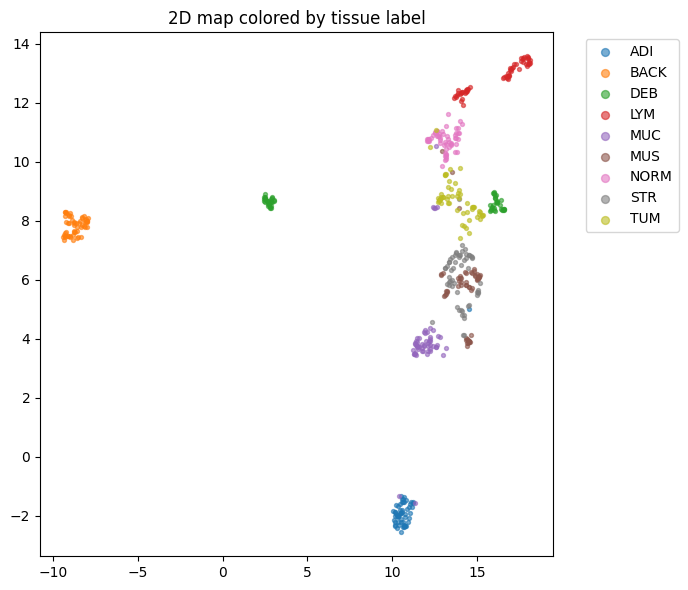

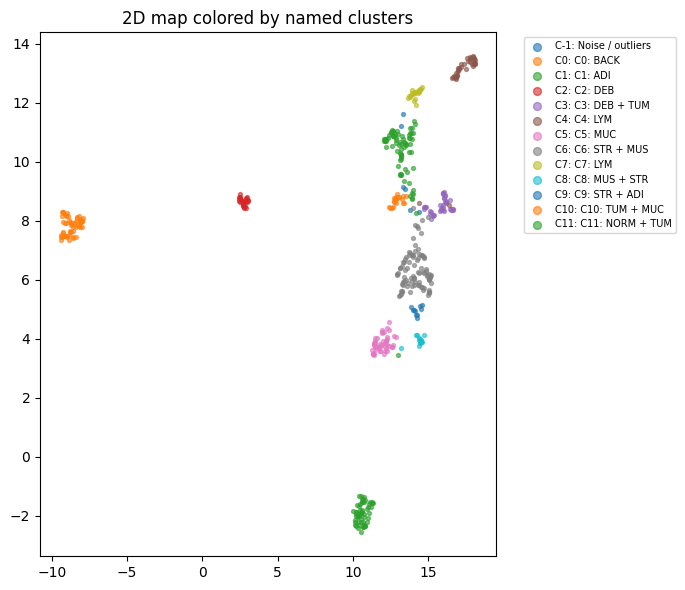

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/map_by_label.png /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/map_by_cluster_named.png


In [18]:

from pathlib import Path
import yaml
import matplotlib.pyplot as plt

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "cartography"
out_dir.mkdir(parents=True, exist_ok=True)

df = map2d_df.merge(clusters_df, on="item_id", how="left").merge(items_df[["item_id","label"]], on="item_id", how="left")

# Downsample for plot speed
if len(df) > 2000:
    dfp = df.sample(n=2000, random_state=int(cfg["project"]["seed"]))
else:
    dfp = df

# Plot by label
plt.figure(figsize=(7,6))
for lab, g in dfp.groupby("label"):
    plt.scatter(g["x"], g["y"], s=8, alpha=0.6, label=str(lab))
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
plt.title("2D map colored by tissue label")
plt.tight_layout()
p1 = out_dir / "map_by_label.png"
plt.savefig(p1, dpi=160)
plt.show()

# Plot by cluster (prefer cluster_name if available)
plt.figure(figsize=(7,6))
for cid, g in dfp.groupby("cluster_id"):
    cname = None
    if "cluster_name" in g.columns:
        try:
            cname = g["cluster_name"].dropna().iloc[0]
        except Exception:
            cname = None
    label = f"C{cid}: {cname}" if cname else str(cid)
    plt.scatter(g["x"], g["y"], s=8, alpha=0.6, label=label)

# If many clusters, legends can get huge; you can comment this out if it crowds the figure.
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left", fontsize=7)
plt.title("2D map colored by named clusters")
plt.tight_layout()
p2 = out_dir / "map_by_cluster_named.png"
plt.savefig(p2, dpi=160)
plt.show()

print("Saved:", p1, p2)


<a id="C10.0"></a>
### Cell C10.0 — Save cartography table for downstream use

- **Purpose:** Persist a joined table (item_id, x, y, cluster_id, label) to exports/cartography/.
- **Inputs:** map2d_df, clusters_df, items_df
- **Outputs:** exports/cartography/cartography_table.parquet
- **Depends on:** C6.0,C7.0
- **Writes checkpoints:** exports/cartography/cartography_table.parquet


In [19]:

from pathlib import Path
import yaml

from histo_cartography.exports import save_parquet

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "cartography"
out_dir.mkdir(parents=True, exist_ok=True)

carto = map2d_df.merge(clusters_df, on="item_id", how="left").merge(items_df[["item_id","label","source","split"]], on="item_id", how="left")
out_path = out_dir / "cartography_table.parquet"
save_parquet(carto, out_path)

print("✅ cartography_table saved:", out_path)


from histo_cartography.debug_tools import show_parquet
_ = show_parquet(out_path, title="exports/cartography/cartography_table.parquet", n=10)


INFO:histo_cartography:Saved parquet


✅ cartography_table saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/cartography_table.parquet
📄 exports/cartography/cartography_table.parquet
shape=(512, 10)


,item_id,x,y,cluster_id,cluster_name,purity,entropy,label,source,split
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,10.204427,-1.953747,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,11.016440,-1.694932,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,10.146341,-2.213066,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,10.921078,-2.219363,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,10.453151,-1.927776,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,10.733039,-2.302579,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,10.651013,-2.200732,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,11.179252,-1.722978,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYEVWMFC,10.684698,-2.388524,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
9,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYYTMTTH,10.369753,-2.022917,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val


<a id="C10.1"></a>
### Cell C10.1 — Preview cartography parquet + saved plots

- **Purpose:** Immediately verify the downstream cartography table and show saved cartography plots.
- **Inputs:** exports/cartography/cartography_table.parquet
- **Outputs:** Table preview + inline plots


📄 exports/cartography/cartography_table.parquet
shape=(512, 10)


,item_id,x,y,cluster_id,cluster_name,purity,entropy,label,source,split
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,10.204427,-1.953747,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,11.016440,-1.694932,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,10.146341,-2.213066,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,10.921078,-2.219363,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,10.453151,-1.927776,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,10.733039,-2.302579,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,10.651013,-2.200732,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,11.179252,-1.722978,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYEVWMFC,10.684698,-2.388524,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
9,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DYYTMTTH,10.369753,-2.022917,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val


Found 10 plot(s) in /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots


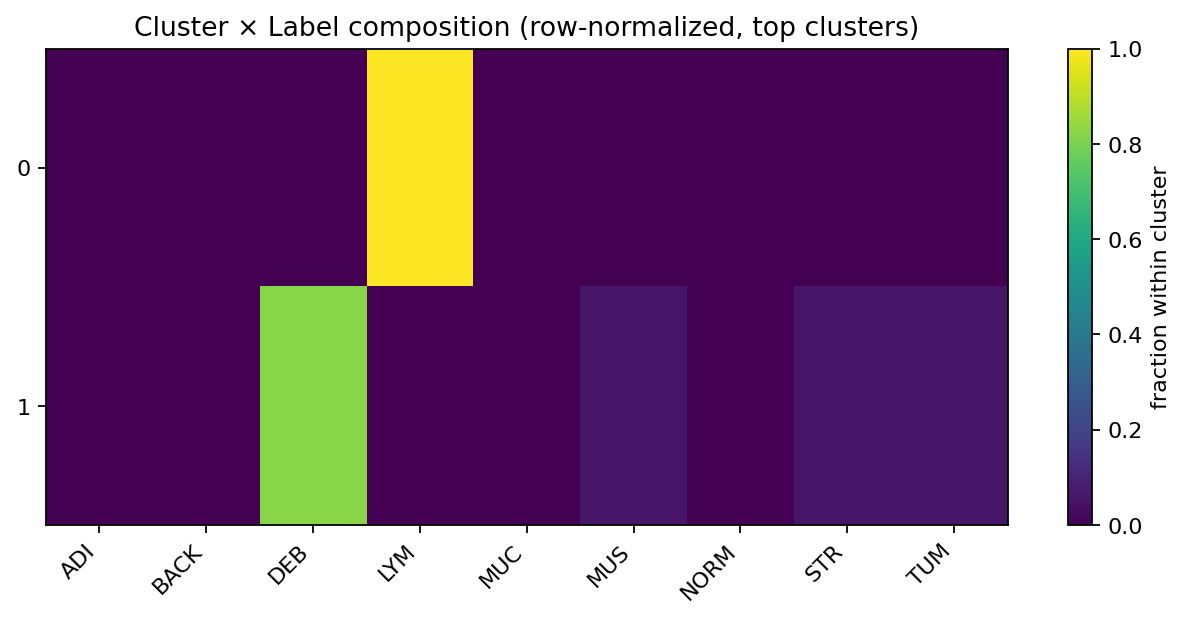

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/cluster_label_heatmap.png


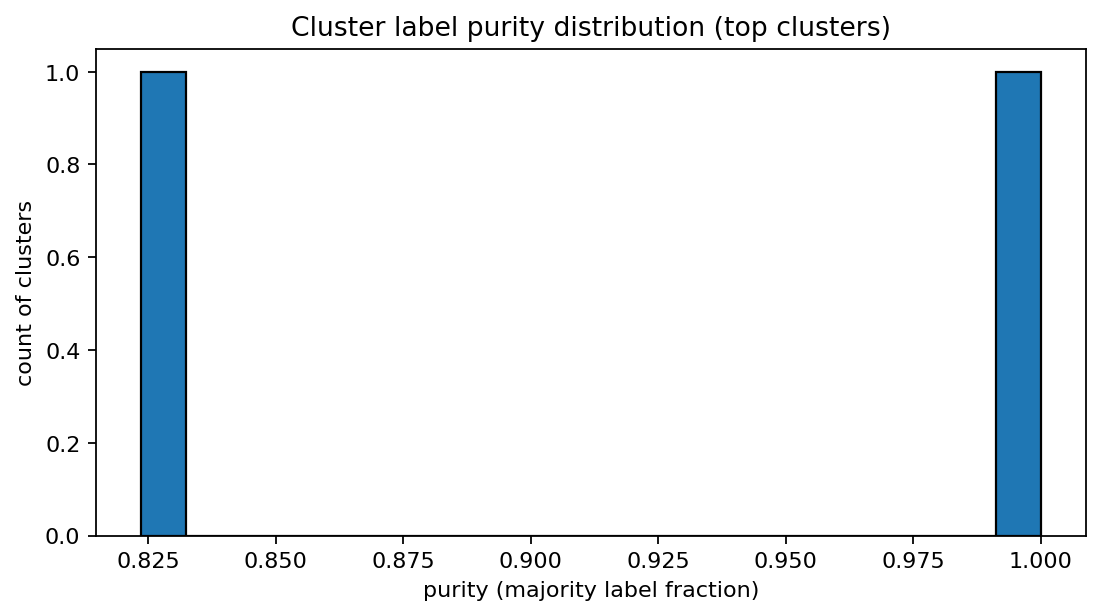

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/cluster_label_purity_hist.png


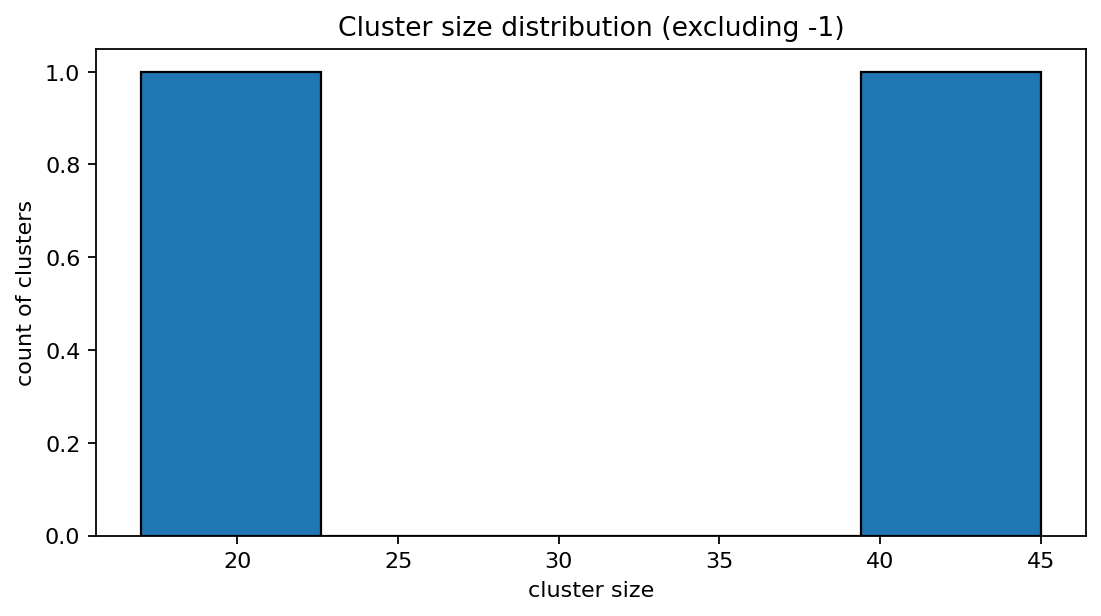

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/cluster_size_hist.png


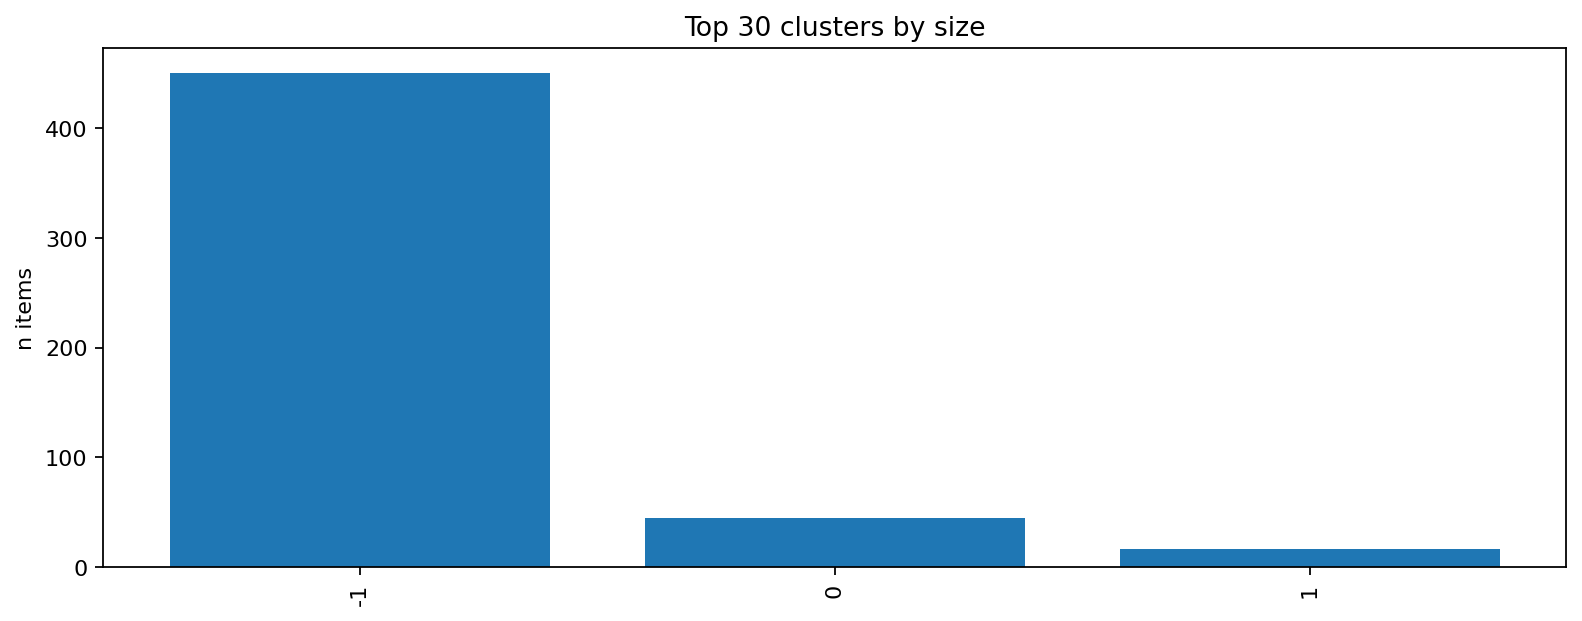

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/cluster_sizes_top30.png


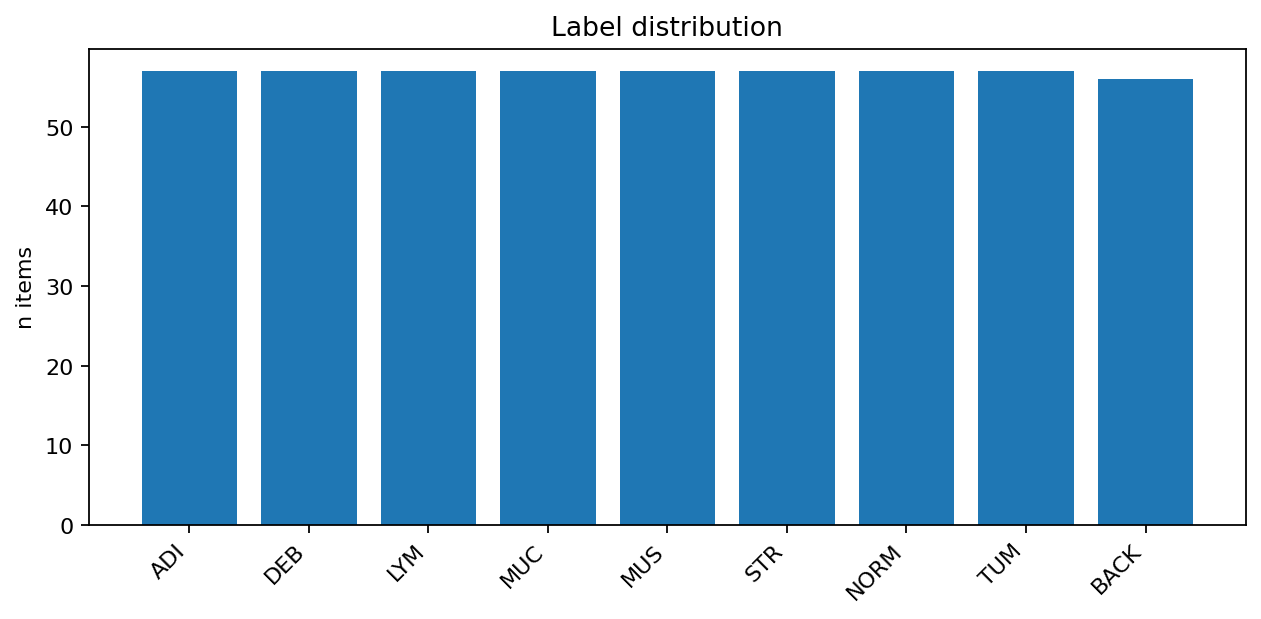

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/label_distribution.png


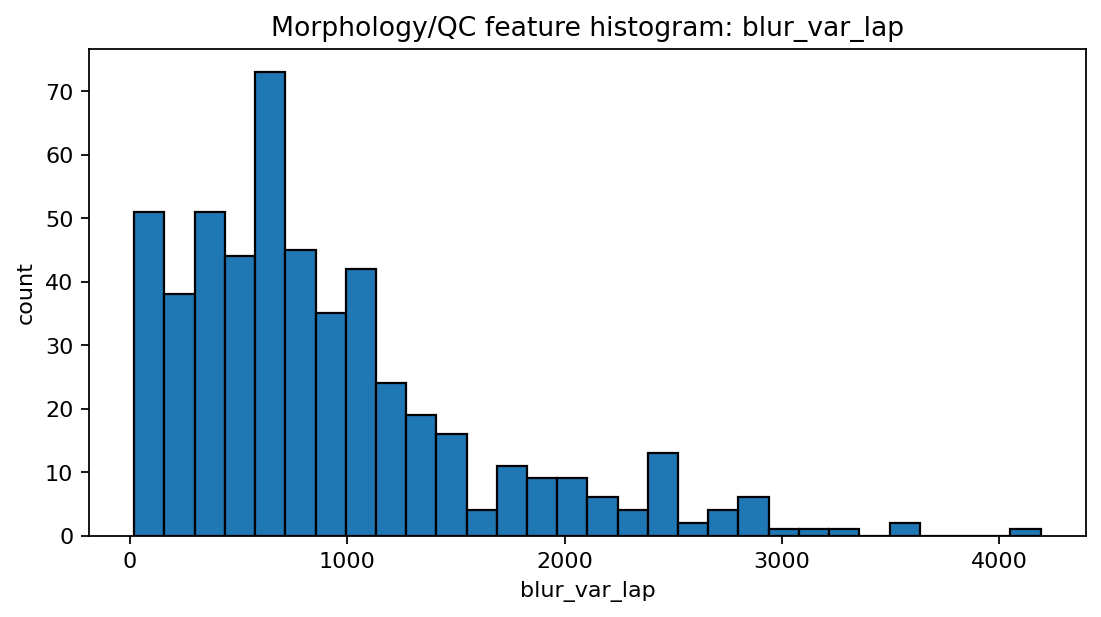

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/morph_hist__blur_var_lap.png


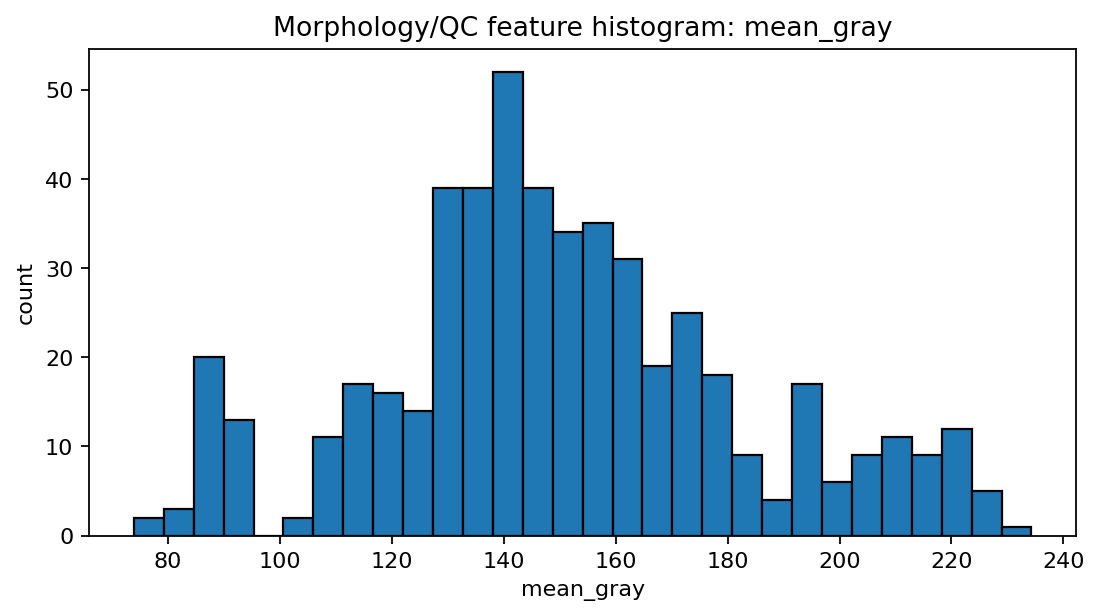

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/morph_hist__mean_gray.png


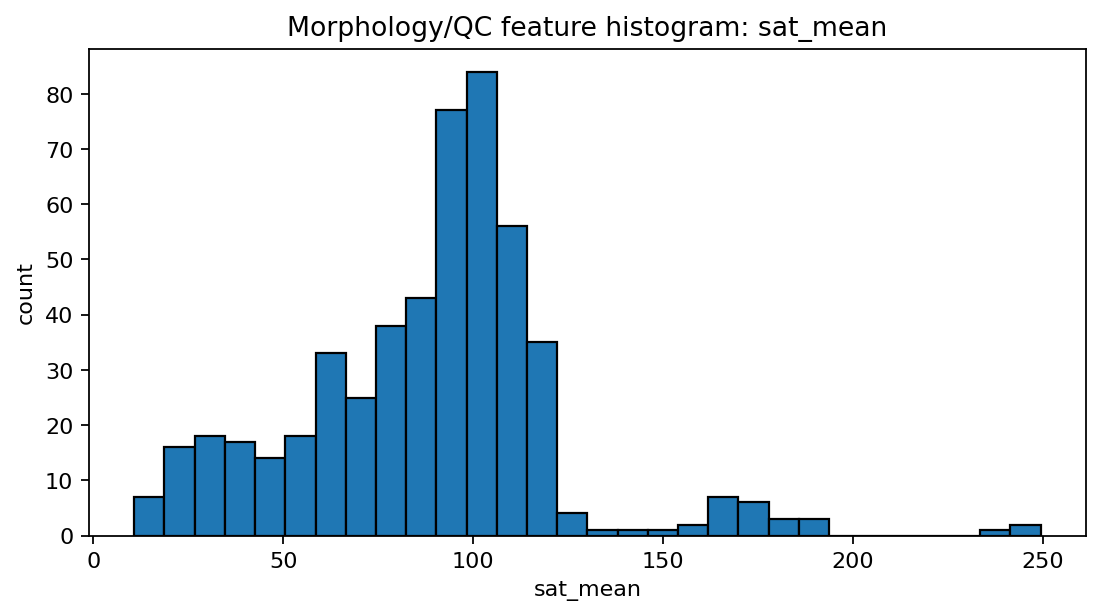

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/morph_hist__sat_mean.png


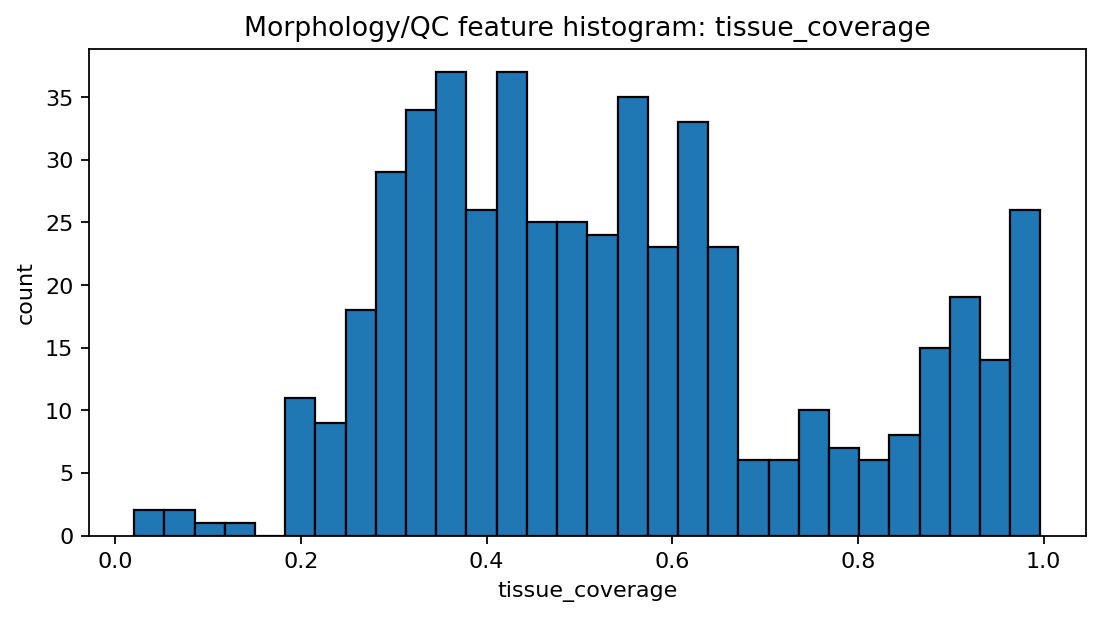

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/morph_hist__tissue_coverage.png


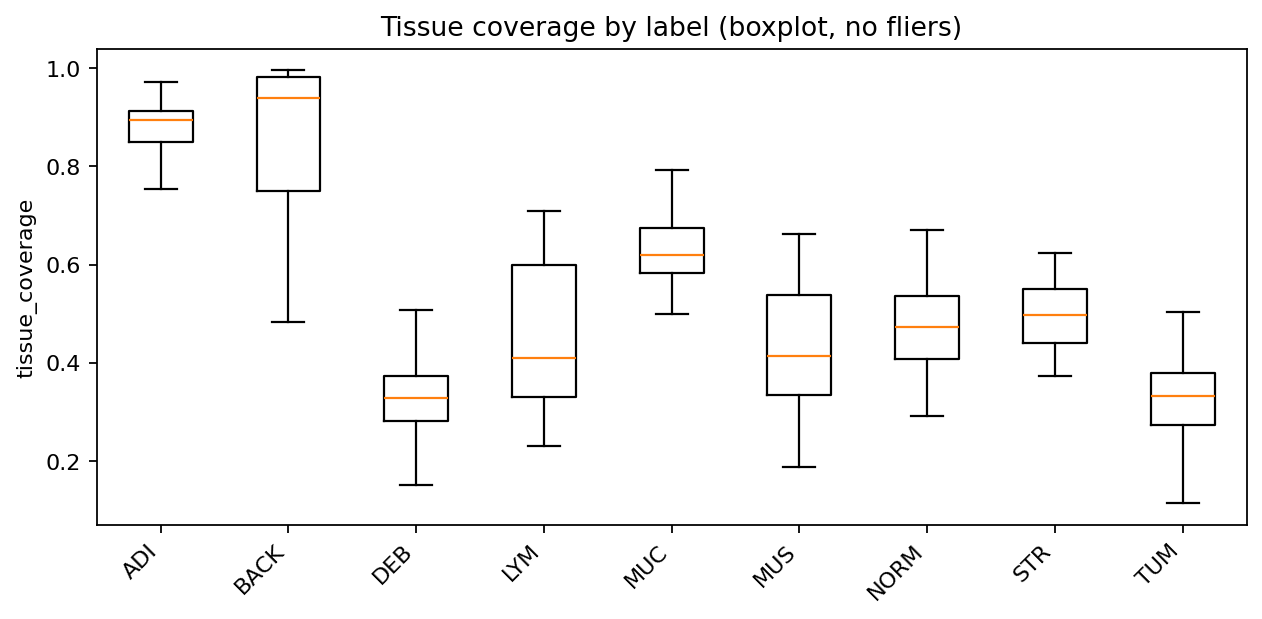

Shown: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/tissue_coverage_by_label_boxplot.png


In [20]:
from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.debug_tools import show_parquet, show_images

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())

carto_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "cartography"
carto_path = carto_dir / "cartography_table.parquet"

if carto_path.exists():
    carto_df = show_parquet(carto_path, title="exports/cartography/cartography_table.parquet", n=10)
else:
    print("ℹ️ Cartography table not found yet:", carto_path)
    carto_df = None

# Show saved cartography plots (if present)
plot_dir = carto_dir / "plots"
if plot_dir.exists():
    imgs = sorted(plot_dir.glob("*.png"))
    print(f"Found {len(imgs)} plot(s) in {plot_dir}")
    show_images(imgs, max_images=12, width=420)
else:
    print("ℹ️ No cartography plots dir yet:", plot_dir)


<a id="C11.0"></a>
### Cell C11.0 — Additional cartography dashboards (cluster diagnostics + QC)

- **Purpose:** Generate additional cluster/cartography visualizations (beyond the quick scatter plots):
  - label distribution
  - cluster size distribution
  - cluster × label composition heatmap (row-normalized)
  - label purity distribution
  - optional morphology/QC feature histograms (if `morph_df` is present)
- **Inputs:** `carto` (or `exports/cartography/cartography_table.parquet`), optional `morph_df`
- **Outputs:** `exports/cartography/plots/*.png`

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/label_distribution.png


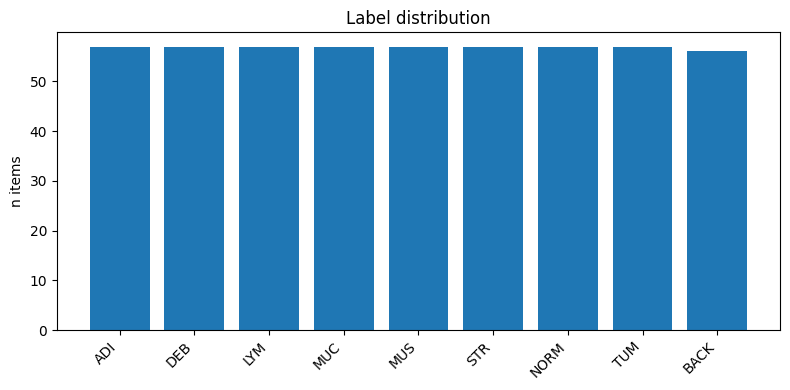

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/cluster_sizes_top30.png


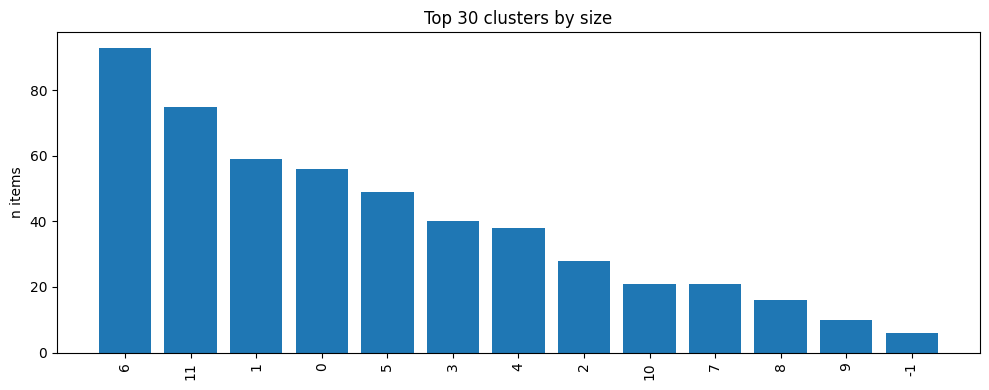

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/cluster_size_hist.png


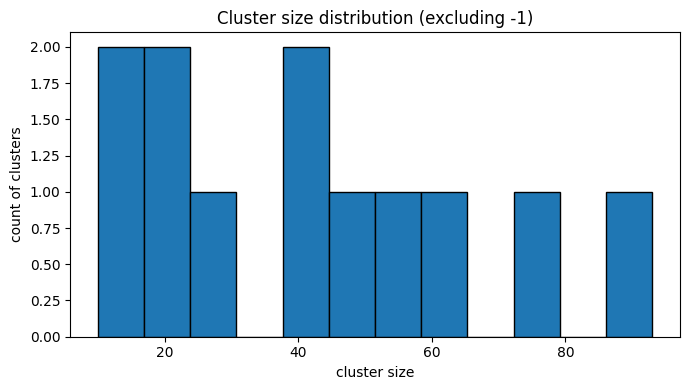

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/cluster_label_heatmap.png


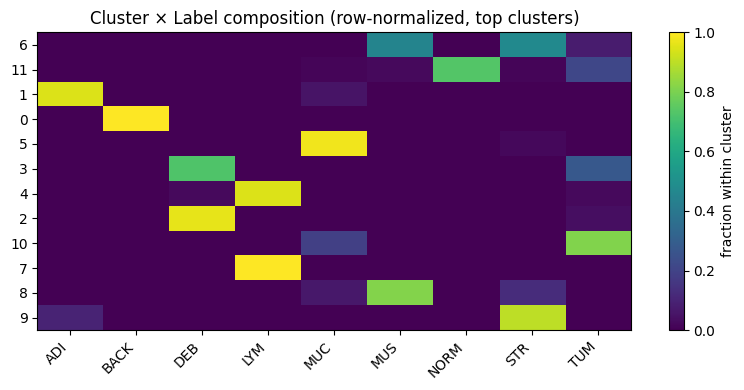

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/cluster_label_purity_hist.png


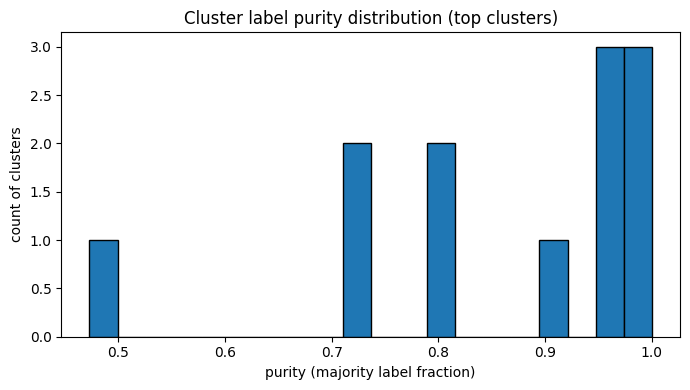

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/morph_hist__tissue_coverage.png


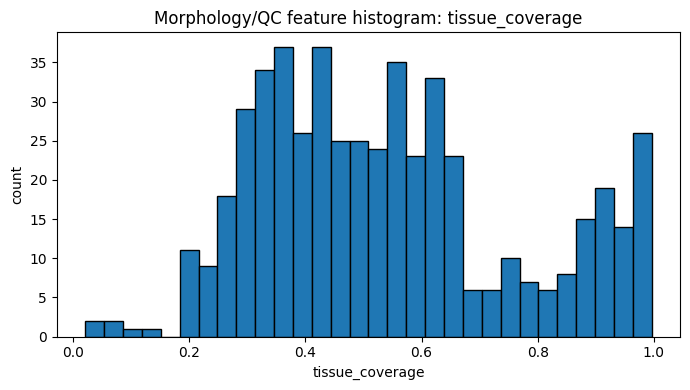

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/morph_hist__blur_var_lap.png


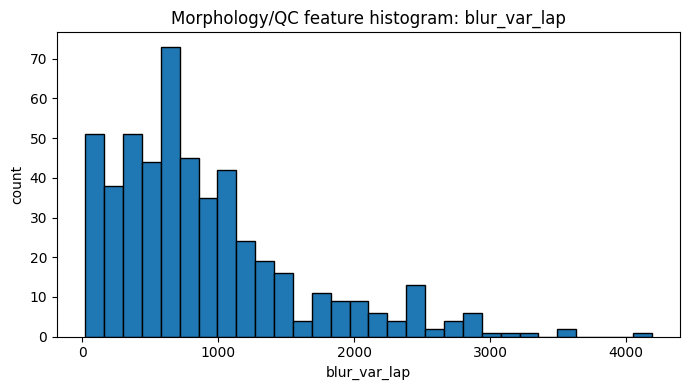

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/morph_hist__mean_gray.png


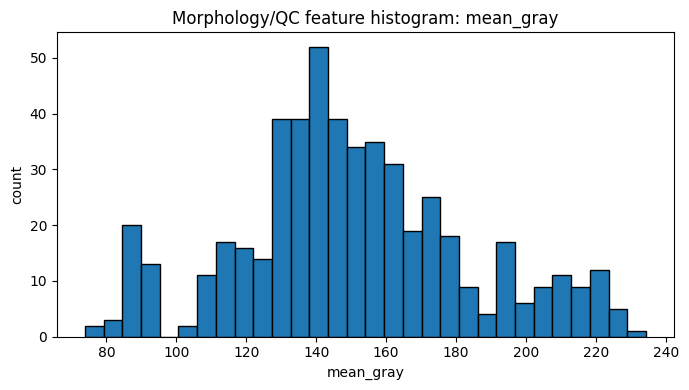

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/morph_hist__sat_mean.png


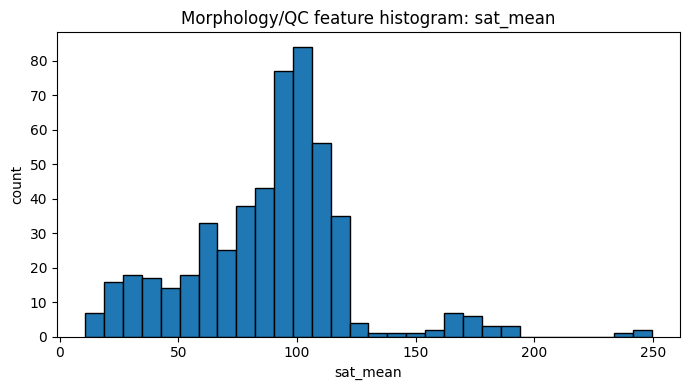

/tmp/ipython-input-2169850749.py:133: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labs, showfliers=False)


Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/cartography/plots/tissue_coverage_by_label_boxplot.png


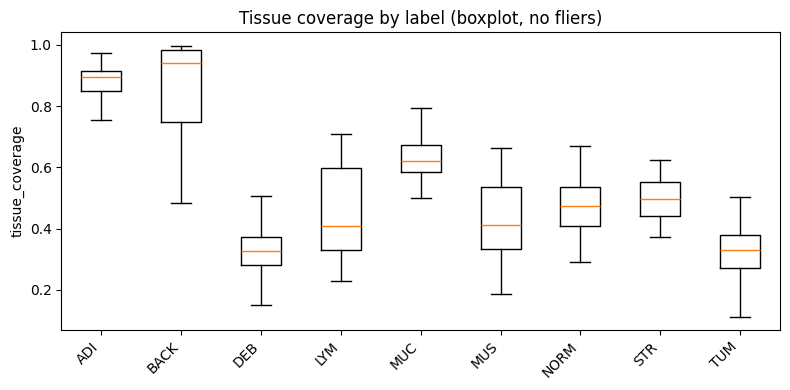

In [21]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "cartography"
plot_dir = out_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

# Load cartography table (prefer in-memory `carto` from C10.0)
if "carto" in globals():
    carto_df = carto.copy()
else:
    carto_path = out_dir / "cartography_table.parquet"
    carto_df = pd.read_parquet(carto_path)

# Normalize cluster_id dtype
if "cluster_id" in carto_df.columns:
    carto_df["cluster_id"] = carto_df["cluster_id"].fillna(-1).astype(int)

def _savefig(name: str):
    p = plot_dir / name
    plt.savefig(p, dpi=160, bbox_inches="tight")
    print("Saved:", p)

# -------------------------
# 1) Label distribution
# -------------------------
if "label" in carto_df.columns:
    lab_counts = carto_df["label"].fillna("NA").astype(str).value_counts()
    plt.figure(figsize=(8, 4))
    plt.bar(lab_counts.index, lab_counts.values)
    plt.xticks(rotation=45, ha="right")
    plt.title("Label distribution")
    plt.ylabel("n items")
    plt.tight_layout()
    _savefig("label_distribution.png")
    plt.show()

# -------------------------
# 2) Cluster size distribution
# -------------------------
if "cluster_id" in carto_df.columns:
    cl_sizes = carto_df["cluster_id"].value_counts().sort_values(ascending=False)
    top = cl_sizes.head(30)

    plt.figure(figsize=(10, 4))
    plt.bar(top.index.astype(str), top.values)
    plt.xticks(rotation=90)
    plt.title("Top 30 clusters by size")
    plt.ylabel("n items")
    plt.tight_layout()
    _savefig("cluster_sizes_top30.png")
    plt.show()

    # Histogram of cluster sizes (exclude noise cluster -1)
    cl_sizes_no_noise = cl_sizes.drop(index=[-1], errors="ignore")
    plt.figure(figsize=(7, 4))
    plt.hist(cl_sizes_no_noise.values, bins=min(30, max(5, len(cl_sizes_no_noise))), edgecolor="black")
    plt.title("Cluster size distribution (excluding -1)")
    plt.xlabel("cluster size")
    plt.ylabel("count of clusters")
    plt.tight_layout()
    _savefig("cluster_size_hist.png")
    plt.show()

# -------------------------
# 3) Cluster × Label composition heatmap (row-normalized)
# -------------------------
if ("cluster_id" in carto_df.columns) and ("label" in carto_df.columns):
    ct = pd.crosstab(carto_df["cluster_id"], carto_df["label"].fillna("NA").astype(str))
    cl_sizes = carto_df["cluster_id"].value_counts().sort_values(ascending=False)

    # focus on most populated clusters for readability
    top_clusters = [c for c in cl_sizes.index.tolist() if c != -1][:25]
    if len(top_clusters) >= 2:
        ct = ct.loc[top_clusters]
        ctn = ct.div(ct.sum(axis=1), axis=0).fillna(0.0)

        plt.figure(figsize=(max(8, 0.6 * len(ctn.columns)), max(4, 0.25 * len(ctn.index))))
        plt.imshow(ctn.values, aspect="auto")
        plt.colorbar(label="fraction within cluster")
        plt.xticks(range(len(ctn.columns)), ctn.columns.tolist(), rotation=45, ha="right")
        plt.yticks(range(len(ctn.index)), [str(x) for x in ctn.index.tolist()])
        plt.title("Cluster × Label composition (row-normalized, top clusters)")
        plt.tight_layout()
        _savefig("cluster_label_heatmap.png")
        plt.show()

        # Purity distribution
        purity = (ct.max(axis=1) / ct.sum(axis=1)).astype(float)
        plt.figure(figsize=(7, 4))
        plt.hist(purity.values, bins=20, edgecolor="black")
        plt.title("Cluster label purity distribution (top clusters)")
        plt.xlabel("purity (majority label fraction)")
        plt.ylabel("count of clusters")
        plt.tight_layout()
        _savefig("cluster_label_purity_hist.png")
        plt.show()

# -------------------------
# 4) Optional morphology/QC feature plots
# -------------------------
if "morph_df" in globals():
    m = morph_df.merge(carto_df[["item_id", "label", "cluster_id"]], on="item_id", how="left")
    # Pick a few high-signal QC-ish features if present
    qc_feats = ["tissue_coverage", "blur_var_lap", "mean_gray", "sat_mean"]
    qc_feats = [f for f in qc_feats if f in m.columns]

    for feat in qc_feats:
        x = pd.to_numeric(m[feat], errors="coerce").dropna().values
        if len(x) == 0:
            continue
        plt.figure(figsize=(7, 4))
        plt.hist(x, bins=30, edgecolor="black")
        plt.title(f"Morphology/QC feature histogram: {feat}")
        plt.xlabel(feat)
        plt.ylabel("count")
        plt.tight_layout()
        _savefig(f"morph_hist__{feat}.png")
        plt.show()

    # Boxplot by label (for tissue_coverage if present)
    if "tissue_coverage" in m.columns and "label" in m.columns:
        labs = sorted(m["label"].dropna().astype(str).unique().tolist())
        data = [pd.to_numeric(m.loc[m["label"].astype(str) == lab, "tissue_coverage"], errors="coerce").dropna().values for lab in labs]
        data = [d for d in data if len(d) > 0]
        labs = [lab for lab, d in zip(labs, data) if len(d) > 0]
        if len(data) >= 2:
            plt.figure(figsize=(max(8, 0.8 * len(labs)), 4))
            plt.boxplot(data, labels=labs, showfliers=False)
            plt.xticks(rotation=45, ha="right")
            plt.title("Tissue coverage by label (boxplot, no fliers)")
            plt.ylabel("tissue_coverage")
            plt.tight_layout()
            _savefig("tissue_coverage_by_label_boxplot.png")
            plt.show()
else:
    print("ℹ️ morph_df not found in memory; skipping morphology/QC plots.")

<a id="C11.5"></a>
### Cell C11.5 — Modality contribution diagnostics (quick ML sanity checks)

- **Purpose:** Quantify how informative each modality embedding is for label prediction and clustering quality.
- **What it does:**
  - Trains a lightweight linear classifier (LogReg) to predict `label` from each embedding type.
  - Computes basic clustering metrics (silhouette / CH / DB) using KMeans for each embedding type.
- **Why it matters:** If one modality dominates or collapses, it will show up here.
- **Notes:** This is *not* a final model—just a fast, explainable diagnostic.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Modality diagnostics (label predictability + clustering metrics)
shape=(4, 9)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,embedding,n,dim,cv_acc,cv_f1_macro,kmeans_k,silhouette,calinski_harabasz,davies_bouldin
0,image,512,2048,0.931639,0.930408,9,0.154865,4.887379e+01,2.106833e+00
1,text,512,30,1.000000,1.000000,9,1.000000,3.131370e+14,7.840413e-07
2,morph,512,15,0.767428,0.763605,9,0.338051,3.249886e+02,1.012362e+00
3,fused,512,256,0.910051,0.909579,9,0.097208,2.400994e+01,3.052837e+00


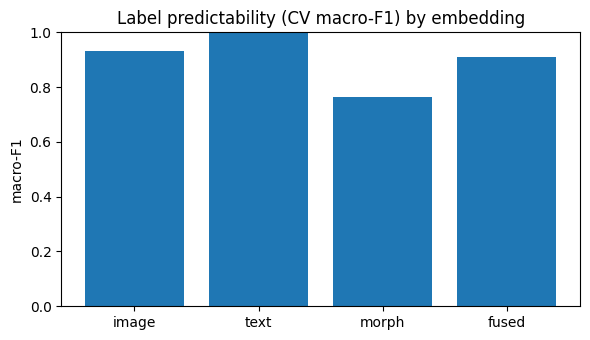

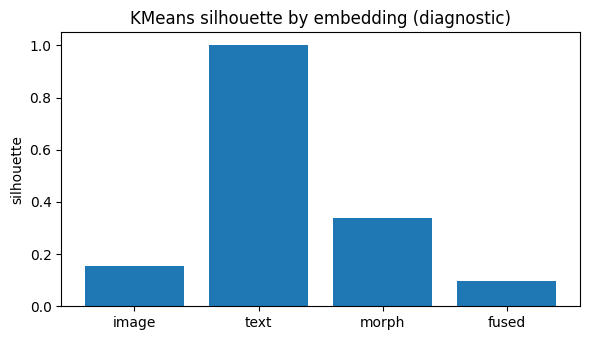

In [22]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from histo_cartography.debug_tools import display_df

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
seed = int(cfg["project"].get("seed", 1337))

# Helper: vector DF -> aligned (X, y)
def _xy(emb_df: pd.DataFrame, items_df: pd.DataFrame, label_col: str = "label"):
    e = emb_df[["item_id", "vector"]].copy()
    m = items_df[["item_id", label_col]].copy()
    df = e.merge(m, on="item_id", how="inner").dropna(subset=[label_col])
    X = np.array(df["vector"].tolist(), dtype=np.float32)
    y = df[label_col].astype(str).to_numpy()
    return X, y, df

emb_sets = {
    "image": image_emb_df if "image_emb_df" in globals() else None,
    "text": text_emb_df if "text_emb_df" in globals() else None,
    "morph": morph_emb_df if "morph_emb_df" in globals() else None,
    "fused": fused_emb_df if "fused_emb_df" in globals() else None,
}

results = []

for name, emb in emb_sets.items():
    if emb is None:
        continue
    try:
        X, y, df_xy = _xy(emb, items_df)
        if len(np.unique(y)) < 2 or len(y) < 10:
            results.append({"embedding": name, "note": "not enough labeled rows"})
            continue

        # --- 1) Label predictability (macro-F1 via CV) ---
        skf = StratifiedKFold(n_splits=min(5, np.min(np.bincount(pd.factorize(y)[0]))), shuffle=True, random_state=seed)
        f1s, accs = [], []
        for tr, te in skf.split(X, y):
            clf = LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="auto")
            clf.fit(X[tr], y[tr])
            pred = clf.predict(X[te])
            accs.append(accuracy_score(y[te], pred))
            f1s.append(f1_score(y[te], pred, average="macro"))
        f1_macro = float(np.mean(f1s))
        acc = float(np.mean(accs))

        # --- 2) Clustering quality (KMeans + metrics) ---
        k = int(cfg.get("cartography", {}).get("kmeans", {}).get("k", 20))
        k = int(max(2, min(k, len(X) - 1)))
        km = KMeans(n_clusters=k, random_state=seed, n_init="auto")
        yk = km.fit_predict(X)
        sil = float(silhouette_score(X, yk)) if len(np.unique(yk)) > 1 else np.nan
        ch = float(calinski_harabasz_score(X, yk)) if len(np.unique(yk)) > 1 else np.nan
        db = float(davies_bouldin_score(X, yk)) if len(np.unique(yk)) > 1 else np.nan

        results.append(
            {
                "embedding": name,
                "n": int(len(y)),
                "dim": int(X.shape[1]),
                "cv_acc": acc,
                "cv_f1_macro": f1_macro,
                "kmeans_k": k,
                "silhouette": sil,
                "calinski_harabasz": ch,
                "davies_bouldin": db,
            }
        )
    except Exception as e:
        results.append({"embedding": name, "error": str(e)})

res_df = pd.DataFrame(results)
display_df(res_df, title="Modality diagnostics (label predictability + clustering metrics)", n=20)

# Simple bar charts (when metrics available)
if "cv_f1_macro" in res_df.columns:
    dfp = res_df.dropna(subset=["cv_f1_macro"]).copy()
    if len(dfp):
        plt.figure(figsize=(6, 3.5))
        plt.bar(dfp["embedding"], dfp["cv_f1_macro"])
        plt.ylim(0, 1)
        plt.title("Label predictability (CV macro-F1) by embedding")
        plt.ylabel("macro-F1")
        plt.tight_layout()
        plt.show()

if "silhouette" in res_df.columns:
    dfp = res_df.dropna(subset=["silhouette"]).copy()
    if len(dfp):
        plt.figure(figsize=(6, 3.5))
        plt.bar(dfp["embedding"], dfp["silhouette"])
        plt.title("KMeans silhouette by embedding (diagnostic)")
        plt.ylabel("silhouette")
        plt.tight_layout()
        plt.show()


<a id="C12.0"></a>
### Cell C12.0 — Knowledge graph summary plots (from KG parquet exports)

> This cell **reads the KG parquet exports** produced by `03_HistoCartography_Knowledge_Graph_Exports.ipynb` and generates
> a few quick, high-value charts. If you haven't run notebook 03 yet, it will safely skip.

- **Inputs:** `exports/kg/entities.parquet`, `exports/kg/edges.parquet`, `exports/kg/provenance.parquet`
- **Outputs:** `exports/kg/plots/*.png`

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_node_counts_by_type.png


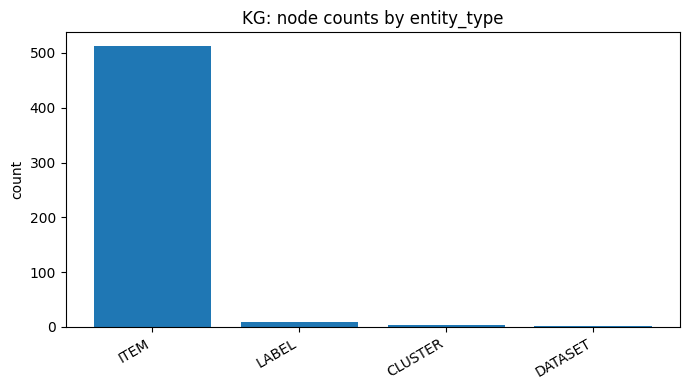

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_edge_counts_by_rel.png


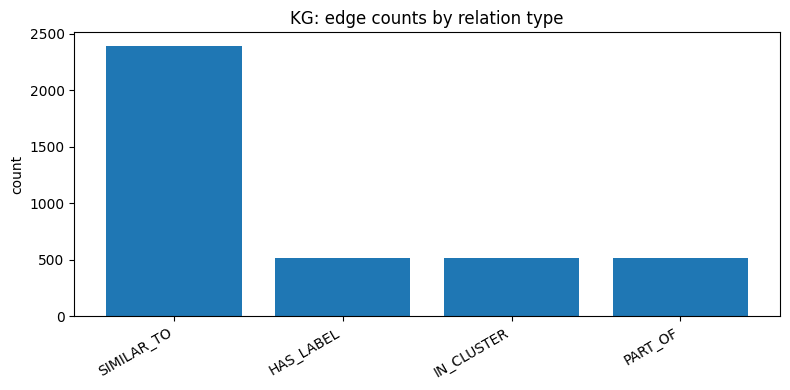

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_similarity_weight_hist.png


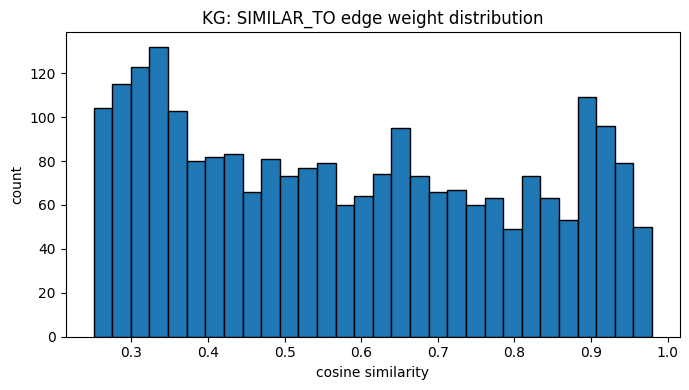

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_top_nodes_by_degree.png


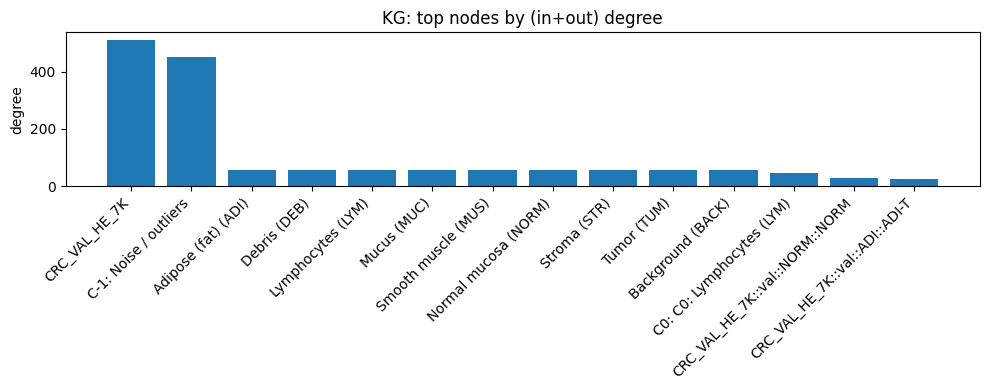

In [23]:
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
kg_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg"
plot_dir = kg_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

entities_path = kg_dir / "entities.parquet"
edges_path = kg_dir / "edges.parquet"
prov_path = kg_dir / "provenance.parquet"

def _savefig(name: str):
    p = plot_dir / name
    plt.savefig(p, dpi=160, bbox_inches="tight")
    print("Saved:", p)

if not (entities_path.exists() and edges_path.exists() and prov_path.exists()):
    print("ℹ️ KG exports not found yet.")
    print("   Run: 03_HistoCartography_Knowledge_Graph_Exports.ipynb")
else:
    entities_df = pd.read_parquet(entities_path)
    edges_df = pd.read_parquet(edges_path)
    prov_df = pd.read_parquet(prov_path)

    # 1) Node counts by type
    if "entity_type" in entities_df.columns:
        vc = entities_df["entity_type"].fillna("NA").astype(str).value_counts()
        plt.figure(figsize=(7, 4))
        plt.bar(vc.index, vc.values)
        plt.xticks(rotation=30, ha="right")
        plt.title("KG: node counts by entity_type")
        plt.ylabel("count")
        plt.tight_layout()
        _savefig("kg_node_counts_by_type.png")
        plt.show()

    # 2) Edge counts by relation
    if "rel" in edges_df.columns:
        vc = edges_df["rel"].fillna("NA").astype(str).value_counts()
        plt.figure(figsize=(8, 4))
        plt.bar(vc.index, vc.values)
        plt.xticks(rotation=30, ha="right")
        plt.title("KG: edge counts by relation type")
        plt.ylabel("count")
        plt.tight_layout()
        _savefig("kg_edge_counts_by_rel.png")
        plt.show()

    # 3) Similarity weight distribution (SIMILAR_TO)
    if "rel" in edges_df.columns and "weight" in edges_df.columns:
        sim = edges_df.loc[edges_df["rel"] == "SIMILAR_TO", "weight"]
        sim = pd.to_numeric(sim, errors="coerce").dropna()
        if len(sim):
            plt.figure(figsize=(7, 4))
            plt.hist(sim.values, bins=30, edgecolor="black")
            plt.title("KG: SIMILAR_TO edge weight distribution")
            plt.xlabel("cosine similarity")
            plt.ylabel("count")
            plt.tight_layout()
            _savefig("kg_similarity_weight_hist.png")
            plt.show()

    # 4) Optional: top nodes by degree (computed from edges)
    try:
        import networkx as nx  # pure python, typically available in Colab

        G = nx.DiGraph()
        G.add_nodes_from(entities_df["entity_id"].tolist())
        G.add_edges_from(edges_df[["src", "dst"]].itertuples(index=False, name=None))

        deg = dict(G.degree())
        top = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:15]
        top_ids = [t[0] for t in top]
        top_deg = [t[1] for t in top]
        name_map = entities_df.set_index("entity_id")["name"].to_dict() if "name" in entities_df.columns else {}

        plt.figure(figsize=(10, 4))
        plt.bar([name_map.get(eid, eid)[:30] for eid in top_ids], top_deg)
        plt.xticks(rotation=45, ha="right")
        plt.title("KG: top nodes by (in+out) degree")
        plt.ylabel("degree")
        plt.tight_layout()
        _savefig("kg_top_nodes_by_degree.png")
        plt.show()
    except Exception as e:
        print("ℹ️ networkx degree plot skipped:", e)

<a id="C13.0"></a>
### Cell C13.0 — Show all parquet outputs as tables (quick audit)

- **Purpose:** Print every parquet written by this pipeline as a small table preview.
- **Inputs:** checkpoints/**.parquet, exports/**.parquet
- **Outputs:** Inline table previews


In [24]:
from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.debug_tools import display_df

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())

roots = [
    PROJECT_ROOT / cfg["paths"]["checkpoints_dir"],
    PROJECT_ROOT / cfg["paths"]["exports_dir"],
]

parquets = []
for r in roots:
    if r.exists():
        parquets.extend(sorted(r.rglob("*.parquet")))

if not parquets:
    print("ℹ️ No parquet files found yet under checkpoints/ or exports/. Run the pipeline cells first.")
else:
    print(f"Found {len(parquets)} parquet file(s). Showing up to 30 previews.")
    for p in parquets[:30]:
        try:
            df = pd.read_parquet(p)
            rel = p.relative_to(PROJECT_ROOT)
            display_df(df, title=f"📄 {rel}", n=8)
        except Exception as e:
            print("Failed to read:", p, "|", e)


Found 30 parquet file(s). Showing up to 30 previews.
📄 checkpoints/B/items.parquet
shape=(512, 9)


,item_id,source,split,label,text,image_path,width,height,mpp
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5


📄 checkpoints/C/cluster_summary.parquet
shape=(13, 5)


,cluster_id,n_items,purity,entropy,cluster_name
0,6,93,0.473118,0.907784,C6: STR + MUS
1,11,75,0.733333,0.768808,C11: NORM + TUM
2,1,59,0.949153,0.201003,C1: ADI
3,0,56,1.000000,0.000000,C0: BACK
4,5,49,0.979592,0.099623,C5: MUC
5,3,40,0.725000,0.588169,C3: DEB + TUM
6,4,38,0.947368,0.242673,C4: LYM
7,2,28,0.964286,0.154076,C2: DEB


📄 checkpoints/C/clusters.parquet
shape=(512, 5)


,item_id,cluster_id,cluster_name,purity,entropy
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,1,C1: ADI,0.949153,0.201003
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,1,C1: ADI,0.949153,0.201003
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,1,C1: ADI,0.949153,0.201003
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,1,C1: ADI,0.949153,0.201003
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,1,C1: ADI,0.949153,0.201003
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,1,C1: ADI,0.949153,0.201003
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,1,C1: ADI,0.949153,0.201003
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,1,C1: ADI,0.949153,0.201003


📄 checkpoints/C/fused_embeddings.parquet
shape=(512, 5)


,item_id,modality,model_id,dim,vector
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,fused,concat_pca_256,256,"[0.3550693339364996, 0.011588449371731592, 0.3..."
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,fused,concat_pca_256,256,"[0.26946466673152025, 0.1392038313187151, 0.26..."
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,fused,concat_pca_256,256,"[0.2583954546423906, -0.08075046805714951, 0.3..."
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,fused,concat_pca_256,256,"[0.19361983112873923, -0.004950860434381489, 0..."
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,fused,concat_pca_256,256,"[0.4154080598349636, 0.06617428178734777, 0.28..."
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,fused,concat_pca_256,256,"[0.37255382932008996, 0.06050122365242658, 0.1..."
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,fused,concat_pca_256,256,"[0.40494429149607514, -0.029774909163303716, 0..."
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,fused,concat_pca_256,256,"[0.27274682413632817, 0.14622468833599284, 0.2..."


📄 checkpoints/C/fused_embeddings__image.parquet
shape=(512, 5)


,item_id,modality,model_id,dim,vector
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,fused,concat_pca_256,256,"[0.3492228081579634, -0.0024119422587688547, 0..."
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,fused,concat_pca_256,256,"[0.2610905443465369, -0.13849782370858366, 0.2..."
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,fused,concat_pca_256,256,"[0.2520538835930586, 0.09046083501690089, 0.31..."
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,fused,concat_pca_256,256,"[0.19036467195061252, 0.01389674715911108, 0.0..."
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,fused,concat_pca_256,256,"[0.4112552717050322, -0.061200606184548006, 0...."
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,fused,concat_pca_256,256,"[0.369227996313978, -0.05367634648014215, 0.12..."
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,fused,concat_pca_256,256,"[0.4015665851176191, 0.03503053098619019, 0.22..."
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,fused,concat_pca_256,256,"[0.26644932943487876, -0.13463363458105373, 0...."


📄 checkpoints/C/fused_embeddings__image_morph.parquet
shape=(512, 5)


,item_id,modality,model_id,dim,vector
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,fused,concat_pca_256,256,"[0.3550693339364996, 0.011588449371731592, 0.3..."
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,fused,concat_pca_256,256,"[0.26946466673152025, 0.1392038313187151, 0.26..."
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,fused,concat_pca_256,256,"[0.2583954546423906, -0.08075046805714951, 0.3..."
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,fused,concat_pca_256,256,"[0.19361983112873923, -0.004950860434381489, 0..."
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,fused,concat_pca_256,256,"[0.4154080598349636, 0.06617428178734777, 0.28..."
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,fused,concat_pca_256,256,"[0.37255382932008996, 0.06050122365242658, 0.1..."
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,fused,concat_pca_256,256,"[0.40494429149607514, -0.029774909163303716, 0..."
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,fused,concat_pca_256,256,"[0.27274682413632817, 0.14622468833599284, 0.2..."


📄 checkpoints/C/image_embeddings.parquet
shape=(512, 5)


,item_id,modality,model_id,dim,vector
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,image,torchvision/resnet50_imagenet,2048,"[0.5589615702629089, 0.07792720943689346, 0.50..."
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,image,torchvision/resnet50_imagenet,2048,"[0.3780534565448761, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,image,torchvision/resnet50_imagenet,2048,"[0.0988510474562645, 0.03204520791769028, 0.01..."
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,image,torchvision/resnet50_imagenet,2048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0187046416103..."
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,image,torchvision/resnet50_imagenet,2048,"[0.0, 0.014218938536942005, 0.1506246477365493..."
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,image,torchvision/resnet50_imagenet,2048,"[0.05810416862368584, 0.12287670373916626, 0.0..."
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,image,torchvision/resnet50_imagenet,2048,"[0.08134860545396805, 0.07267668098211288, 0.0..."
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,image,torchvision/resnet50_imagenet,2048,"[0.007084301672875881, 0.0, 0.0028630066663026..."


📄 checkpoints/C/map2d.parquet
shape=(512, 3)


,item_id,x,y
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,10.204427,-1.953747
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,11.016440,-1.694932
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,10.146341,-2.213066
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,10.921078,-2.219363
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,10.453151,-1.927776
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,10.733039,-2.302579
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,10.651013,-2.200732
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,11.179252,-1.722978


📄 checkpoints/C/morph.parquet
shape=(512, 16)


,item_id,morph_error,mean_r,mean_g,mean_b,std_r,std_g,std_b,mean_gray,std_gray,tissue_coverage,blur_var_lap,sat_mean,sat_std,width,height
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,0,224.462153,206.149613,224.437978,26.533871,38.995551,25.759346,213.709323,33.337798,0.902782,408.122817,26.013094,29.523366,224,224
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,0,234.861149,220.193698,233.449219,18.425649,30.947835,19.535261,226.074318,25.591029,0.903480,218.804757,18.397660,21.556404,224,224
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,0,230.997848,218.373266,230.791574,20.240113,31.194043,21.557493,223.594607,26.571445,0.938317,316.168526,17.506019,23.084462,224,224
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,0,215.190729,184.521385,209.915796,34.656161,52.600054,36.089298,196.579201,44.836750,0.740414,55.485891,43.083725,39.587154,224,224
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,0,227.643196,209.525969,226.074558,24.808429,38.201199,26.941422,216.840422,32.574786,0.904795,511.881986,24.580596,28.358232,224,224
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,0,209.283402,182.501993,208.967136,32.323067,44.546704,35.965396,193.530752,39.190609,0.872349,1433.256759,42.622150,37.022444,224,224
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,0,212.458247,190.251096,214.844846,25.351603,36.773077,28.771662,199.699637,31.939416,0.908542,861.805490,35.492467,29.129475,224,224
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,0,225.676160,197.579062,218.730947,28.703720,48.910694,33.786436,208.398637,40.464764,0.817801,1057.024657,36.979512,38.856732,224,224


📄 checkpoints/C/morph_embeddings.parquet
shape=(512, 5)


,item_id,modality,model_id,dim,vector
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,morphology,morph_standardized/15,15,"[0.0, 1.4539846181869507, 2.0059986114501953, ..."
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,morphology,morph_standardized/15,15,"[0.0, 1.8219432830810547, 2.3683664798736572, ..."
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,morphology,morph_standardized/15,15,"[0.0, 1.685244083404541, 2.3213953971862793, 1..."
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,morphology,morph_standardized/15,15,"[0.0, 1.125923991203308, 1.4479435682296753, 0..."
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,morphology,morph_standardized/15,15,"[0.0, 1.5665428638458252, 2.09311580657959, 1...."
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,morphology,morph_standardized/15,15,"[0.0, 0.9168988466262817, 1.3958388566970825, ..."
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,morphology,morph_standardized/15,15,"[0.0, 1.0292377471923828, 1.5957825183868408, ..."
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,morphology,morph_standardized/15,15,"[0.0, 1.496941089630127, 1.7848598957061768, 1..."


📄 checkpoints/C/text_embeddings.parquet
shape=(512, 5)


,item_id,modality,model_id,dim,vector
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,text,tfidf_svd/8192_svd30,30,"[0.6776768565177917, 6.151730965900536e-17, 2...."
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,text,tfidf_svd/8192_svd30,30,"[0.6776768565177917, 6.151730965900536e-17, 2...."
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,text,tfidf_svd/8192_svd30,30,"[0.6776768565177917, 6.151730965900536e-17, 2...."
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,text,tfidf_svd/8192_svd30,30,"[0.6776768565177917, 6.151730965900536e-17, 2...."
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,text,tfidf_svd/8192_svd30,30,"[0.6776768565177917, 6.151730965900536e-17, 2...."
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,text,tfidf_svd/8192_svd30,30,"[0.6776768565177917, 6.151730965900536e-17, 2...."
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,text,tfidf_svd/8192_svd30,30,"[0.6776768565177917, 6.151730965900536e-17, 2...."
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,text,tfidf_svd/8192_svd30,30,"[0.6776768565177917, 6.151730965900536e-17, 2...."


📄 checkpoints/D/edges.parquet
shape=(3928, 6)


,edge_id,src,dst,rel,weight,provenance_id
0,edge:166b4035be03e8ad,item:d1b0b94867fce436,label:468fa574010660af,HAS_LABEL,1.0,prov:166b4035be03e8ad
1,edge:e59cc9681cc083fc,item:d1b0b94867fce436,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:e59cc9681cc083fc
2,edge:d82aa392f786e298,item:d1b0b94867fce436,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:d82aa392f786e298
3,edge:d0ffde6d48cfe8ff,item:b76a0e328c9c5611,label:468fa574010660af,HAS_LABEL,1.0,prov:d0ffde6d48cfe8ff
4,edge:578ad7c6b8b9302d,item:b76a0e328c9c5611,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:578ad7c6b8b9302d
5,edge:5a6f2e381b1e3514,item:b76a0e328c9c5611,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:5a6f2e381b1e3514
6,edge:5253ac4c6814bbda,item:8736beaf995d075d,label:468fa574010660af,HAS_LABEL,1.0,prov:5253ac4c6814bbda
7,edge:4443d58e270369f8,item:8736beaf995d075d,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:4443d58e270369f8


📄 checkpoints/D/entities.parquet
shape=(525, 4)


,entity_id,entity_type,name,description
0,dataset:78590ff8ad5886ec,DATASET,CRC_VAL_HE_7K,Histopathology dataset source: CRC_VAL_HE_7K
1,label:468fa574010660af,LABEL,Adipose (fat) (ADI),Tissue class label code=ADI
2,label:587eac1112fa27cc,LABEL,Background (BACK),Tissue class label code=BACK
3,label:d0544fd03bdebef5,LABEL,Debris (DEB),Tissue class label code=DEB
4,label:60c8d13a6ec928e7,LABEL,Lymphocytes (LYM),Tissue class label code=LYM
5,label:f25b4a998c73cf64,LABEL,Mucus (MUC),Tissue class label code=MUC
6,label:4bf6b5d5881cf02a,LABEL,Smooth muscle (MUS),Tissue class label code=MUS
7,label:e27c4ddd9043fd7e,LABEL,Normal mucosa (NORM),Tissue class label code=NORM


📄 checkpoints/D/provenance.parquet
shape=(3928, 5)


,provenance_id,source_item_id,evidence_type,evidence,confidence
0,prov:166b4035be03e8ad,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.label=ADI,1.0
1,prov:e59cc9681cc083fc,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,cluster_id=-1,1.0
2,prov:d82aa392f786e298,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.source=CRC_VAL_HE_7K,1.0
3,prov:d0ffde6d48cfe8ff,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.label=ADI,1.0
4,prov:578ad7c6b8b9302d,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,cluster_id=-1,1.0
5,prov:5a6f2e381b1e3514,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.source=CRC_VAL_HE_7K,1.0
6,prov:5253ac4c6814bbda,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.label=ADI,1.0
7,prov:4443d58e270369f8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,cluster_id=-1,1.0


📄 exports/cartography/cartography_table.parquet
shape=(512, 10)


,item_id,x,y,cluster_id,cluster_name,purity,entropy,label,source,split
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,10.204427,-1.953747,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,11.016440,-1.694932,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,10.146341,-2.213066,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,10.921078,-2.219363,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,10.453151,-1.927776,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,10.733039,-2.302579,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,10.651013,-2.200732,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,11.179252,-1.722978,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val


📄 exports/clustering/kmeans_assignments.parquet
shape=(512, 2)


,item_id,cluster_id
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,7
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,7
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,7
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,7
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,7
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,7
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,7
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,7


📄 exports/kg/cluster_label_counts_matrix.parquet
shape=(3, 10)


,cluster_id,ADI,BACK,DEB,LYM,MUC,MUS,NORM,STR,TUM
0,-1,57,56,43,12,57,56,57,56,56
1,0,0,0,0,45,0,0,0,0,0
2,1,0,0,14,0,0,1,0,1,1


📄 exports/kg/cluster_label_fraction_matrix.parquet
shape=(3, 10)


,cluster_id,ADI,BACK,DEB,LYM,MUC,MUS,NORM,STR,TUM
0,-1,0.126667,0.124444,0.095556,0.026667,0.126667,0.124444,0.126667,0.124444,0.124444
1,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0.000000,0.000000,0.823529,0.000000,0.000000,0.058824,0.000000,0.058824,0.058824


📄 exports/kg/cluster_label_purity.parquet
shape=(3, 4)


,cluster_id,n_items,top_label,purity
0,-1,450,ADI,0.126667
1,0,45,LYM,1.000000
2,1,17,DEB,0.823529


📄 exports/kg/cluster_sizes.parquet
shape=(3, 2)


,cluster_id,n_items
0,-1,450
1,0,45
2,1,17


📄 exports/kg/derived/cluster_adjacency_counts.parquet
shape=(3, 4)


,cluster_id,-1,0,1
0,-1,1952,49,81
1,0,15,210,0
2,1,20,0,65


📄 exports/kg/derived/similarity_by_label.parquet
shape=(9, 4)


,src_label,n_edges,same_label_ratio,mean_weight
0,DEB,285,1.000000,0.757596
1,LYM,285,1.000000,0.897930
2,STR,279,0.835125,0.600929
3,BACK,277,1.000000,0.614892
4,NORM,267,0.910112,0.457775
5,ADI,264,0.973485,0.350304
6,MUS,248,0.822581,0.544448
7,MUC,245,0.934694,0.543314


📄 exports/kg/edge_counts_by_rel.parquet
shape=(4, 2)


,rel,count
0,SIMILAR_TO,2392
1,HAS_LABEL,512
2,IN_CLUSTER,512
3,PART_OF,512


📄 exports/kg/edges.parquet
shape=(3928, 6)


,edge_id,src,dst,rel,weight,provenance_id
0,edge:166b4035be03e8ad,item:d1b0b94867fce436,label:468fa574010660af,HAS_LABEL,1.0,prov:166b4035be03e8ad
1,edge:e59cc9681cc083fc,item:d1b0b94867fce436,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:e59cc9681cc083fc
2,edge:d82aa392f786e298,item:d1b0b94867fce436,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:d82aa392f786e298
3,edge:d0ffde6d48cfe8ff,item:b76a0e328c9c5611,label:468fa574010660af,HAS_LABEL,1.0,prov:d0ffde6d48cfe8ff
4,edge:578ad7c6b8b9302d,item:b76a0e328c9c5611,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:578ad7c6b8b9302d
5,edge:5a6f2e381b1e3514,item:b76a0e328c9c5611,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:5a6f2e381b1e3514
6,edge:5253ac4c6814bbda,item:8736beaf995d075d,label:468fa574010660af,HAS_LABEL,1.0,prov:5253ac4c6814bbda
7,edge:4443d58e270369f8,item:8736beaf995d075d,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:4443d58e270369f8


📄 exports/kg/entities.parquet
shape=(525, 4)


,entity_id,entity_type,name,description
0,dataset:78590ff8ad5886ec,DATASET,CRC_VAL_HE_7K,Histopathology dataset source: CRC_VAL_HE_7K
1,label:468fa574010660af,LABEL,Adipose (fat) (ADI),Tissue class label code=ADI
2,label:587eac1112fa27cc,LABEL,Background (BACK),Tissue class label code=BACK
3,label:d0544fd03bdebef5,LABEL,Debris (DEB),Tissue class label code=DEB
4,label:60c8d13a6ec928e7,LABEL,Lymphocytes (LYM),Tissue class label code=LYM
5,label:f25b4a998c73cf64,LABEL,Mucus (MUC),Tissue class label code=MUC
6,label:4bf6b5d5881cf02a,LABEL,Smooth muscle (MUS),Tissue class label code=MUS
7,label:e27c4ddd9043fd7e,LABEL,Normal mucosa (NORM),Tissue class label code=NORM


📄 exports/kg/interactive/graph_gallery_index.parquet
shape=(1, 7)


,title,html_path,n_nodes,n_edges,items_per_cluster,top_cluster_edges,top_labels_per_cluster
0,"All clusters (meaningful names, cluster-colore...",/content/drive/MyDrive/mit/histopathology_2025...,31,63,6,4,3


📄 exports/kg/kg_libraries_cheatsheet.parquet
shape=(36, 4)


,library,language,category,notes
0,Neo4j,Server,Graph database,Property graph DB; Cypher query language
1,Memgraph,Server,Graph database,"Cypher-compatible, high-performance"
2,TigerGraph,Server,Graph database,Enterprise graph analytics platform
3,ArangoDB,Server,Multi-model DB,Document+graph; AQL queries
4,JanusGraph,Server,Graph database,Distributed graph DB; backends (Cassandra/HBase)
5,Dgraph,Server,Graph database,GraphQL+-style queries; distributed
6,Amazon Neptune,Cloud,Managed graph DB,Property graph + RDF (SPARQL) managed
7,Azure Cosmos DB (Gremlin),Cloud,Managed graph DB,Gremlin API over Cosmos DB


📄 exports/kg/node_counts_by_type.parquet
shape=(4, 2)


,entity_type,count
0,ITEM,512
1,LABEL,9
2,CLUSTER,3
3,DATASET,1


📄 exports/kg/node_degree_table.parquet
shape=(525, 4)


,entity_id,degree,entity_type,name
0,dataset:78590ff8ad5886ec,512,DATASET,CRC_VAL_HE_7K
1,cluster:7984b0a0e139caba,450,CLUSTER,C-1: Noise / outliers
2,label:468fa574010660af,57,LABEL,Adipose (fat) (ADI)
3,label:f25b4a998c73cf64,57,LABEL,Mucus (MUC)
4,label:60c8d13a6ec928e7,57,LABEL,Lymphocytes (LYM)
5,label:e27c4ddd9043fd7e,57,LABEL,Normal mucosa (NORM)
6,label:d0544fd03bdebef5,57,LABEL,Debris (DEB)
7,label:5c0138f240053e6e,57,LABEL,Stroma (STR)


📄 exports/kg/provenance.parquet
shape=(3928, 5)


,provenance_id,source_item_id,evidence_type,evidence,confidence
0,prov:166b4035be03e8ad,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.label=ADI,1.0
1,prov:e59cc9681cc083fc,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,cluster_id=-1,1.0
2,prov:d82aa392f786e298,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.source=CRC_VAL_HE_7K,1.0
3,prov:d0ffde6d48cfe8ff,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.label=ADI,1.0
4,prov:578ad7c6b8b9302d,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,cluster_id=-1,1.0
5,prov:5a6f2e381b1e3514,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.source=CRC_VAL_HE_7K,1.0
6,prov:5253ac4c6814bbda,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.label=ADI,1.0
7,prov:4443d58e270369f8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,cluster_id=-1,1.0
